# Initializing QTLab stuff

In [37]:
%run C:\qtlab_replacement\init.py
from instruments import *
import numpy as np
import sweep
import pandas as pd
from save_pkl import *
from IPython.display import clear_output

In [2]:
#import os
#os.chdir("C:\qtlab_replacement\instruments\_labbrick")

# Iniatializing Plotting and auxilary tools

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import pickle
import re

# Создаем форматер
formatter = matplotlib.ticker.ScalarFormatter ()
formatter.set_powerlimits((-3, 1))
hfont = {'fontname':'Arial'}

from playsound import playsound

from ipywidgets import IntProgress
from IPython.display import display
import time

In [39]:
def zero_sound():
    playsound(r'C:\\qtlab_replacement\\voise\\zero.mp3')
def complete_sound():
    playsound(r'C:\\qtlab_replacement\\voise\\complete.mp3')    
def stable_sound():
    playsound(r'C:\\qtlab_replacement\\voise\\stable.mp3')  
def lockin_complete_sound():
    playsound(r'C:\\qtlab_replacement\\voise\\lockin_complete.mp3')
def magnetic_stable_sound():
    playsound(r'C:\\qtlab_replacement\\voise\\magnetic_stable.mp3')    

In [40]:
def status():
    magnet_state = int(magnet.get_rampingstate())
    if (magnet_state == 1):
        print('RAMPING to target field/current')
    if (magnet_state == 2):
        print('HOLDING at the target field/current')
    if (magnet_state == 3):
        print('PAUSED')
    if (magnet_state == 4):
        print('Ramping in MANUAL UP mode')
    if (magnet_state == 5):
        print('Ramping in MANUAL DOWN mode')
    if (magnet_state == 6):
        print('ZEROING CURRENT (in progress)')
    if (magnet_state == 7):
        print('Quench detected')
    if (magnet_state == 8):
        print('At ZERO current')
    if (magnet_state == 9):
        print('Heating persistent switch')
    if (magnet_state == 10):
        print('Cooling persistent switch')

In [41]:
def freq_to_field(frequency):
    return frequency/28
def field_to_freq(field):
    return field*28
def kelvin_to_GHz(kelvin):
    return 20.8334*kelvin
def GHz_to_kelvin(GHz):
    return 0.048*GHz

def get_mult_freq(frequency):
    return frequency/12
def get_der_freq(frequency):
    return frequency*12

# Initializing Voltage/Current sourses:

In [303]:
current_src_TC = Yokogawa_GS210(address='gs210_1')
current_src_TM = Yokogawa_GS210(address='gs210_3')
current_src_BM = Yokogawa_GS210(address='gs210_4')
current_src_BC = Yokogawa_GS210(address='gs210_5')
current_src_BO = Yokogawa_GS210(address='gs210_7')

In [373]:
current_src_TC.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_TC.set_range(30)                                         # set voltage Source Range
current_src_TC.set_voltage_limits(minvoltage = -25, maxvoltage = 25)   # set the +- maximum voltage ranges in [volts]
current_src_TM.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_TM.set_range(30)                                         # set voltage Source Range
current_src_TM.set_voltage_limits(minvoltage = -25, maxvoltage = 25)   # set the +- maximum voltage ranges in [volts]

In [305]:
current_src_BM.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_BM.set_range(30)                                         # set voltage Source Range
current_src_BM.set_voltage_limits(minvoltage = -20, maxvoltage = 20)   # set the +- maximum voltage ranges in [volts]
current_src_BC.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_BC.set_range(30)                                         # set voltage Source Range
current_src_BC.set_voltage_limits(minvoltage = -20, maxvoltage = 20)   # set the +- maximum voltage ranges in [volts]
current_src_BO.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_BO.set_range(30)                                         # set voltage Source Range
current_src_BO.set_voltage_limits(minvoltage = -20, maxvoltage = 20)   # set the +- maximum voltage ranges in [volts]

In [44]:
current_src_BM.get_status()                                          # check he status 0 - off, 1 - on

0

In [309]:
current_src_TC.set_voltage(0.0)
current_src_TM.set_voltage(0.0)

Voltage set 0e+00 V
Voltage set 0e+00 V


True

In [310]:
current_src_TC.set_status(1)
current_src_TM.set_status(1)

True

In [306]:
current_src_BC.set_voltage(-2.0)
current_src_BM.set_voltage(-2.0)
current_src_BO.set_voltage(-2.0)

Voltage set -2e+00 V
Voltage set -2e+00 V
Voltage set -2e+00 V


True

In [307]:
current_src_BC.set_status(1)
current_src_BM.set_status(1)
current_src_BO.set_status(1)

True

# Slow ramp the voltage on multiple sourses

In [46]:
def ramp_3_sourses(BC,BM,BO, sound = True):
    src_list = [current_src_BC,current_src_BM,current_src_BO]
    BC_BM_BO = np.array([BC,BM,BO])                           # Final values in [Volts]
    STEP = 0.03                                                       # Value of the step in [Volts]

    BC_BM_BO_now = np.array([src_list[0].get_voltage(),src_list[1].get_voltage(),src_list[2].get_voltage()])

    number_list = [abs(BC_BM_BO[0]-BC_BM_BO_now[0]),abs(BC_BM_BO[1]-BC_BM_BO_now[1]),abs(BC_BM_BO[2]-BC_BM_BO_now[2])]
    max_value = max(number_list)
    max_index = number_list.index(max_value)
    steps_BC = list(np.linspace(BC_BM_BO_now[0], BC_BM_BO[0], int(number_list[0]/STEP+1)))
    steps_BM = list(np.linspace(BC_BM_BO_now[1], BC_BM_BO[1], int(number_list[1]/STEP+1)))
    steps_BO = list(np.linspace(BC_BM_BO_now[2], BC_BM_BO[2], int(number_list[2]/STEP+1)))
    for i in np.linspace(BC_BM_BO_now[max_index], BC_BM_BO[max_index], int(number_list[max_index]/STEP+1)):
        clear_output(wait=True)
        if len(steps_BC):
            src_list[0].set_voltage(steps_BC[0])
            steps_BC.pop(0)
        if len(steps_BM):
            src_list[1].set_voltage(steps_BM[0])
            steps_BM.pop(0)
        if len(steps_BO):
            src_list[2].set_voltage(steps_BO[0])
            steps_BO.pop(0)
        sleep(0.1)
    if sound:
        stable_sound()

In [314]:
def ramp_2_sourses(TC,TM, sound = True):
    src_list = [current_src_TC,current_src_TM]
    TC_TM = np.array([TC,TM])                           # Final values in [Volts]
    STEP = 0.03                                                       # Value of the step in [Volts]

    TC_TM_now = np.array([src_list[0].get_voltage(),src_list[1].get_voltage()])

    number_list = [abs(TC_TM[0]-TC_TM_now[0]),abs(TC_TM[1]-TC_TM_now[1])]
    max_value = max(number_list)
    max_index = number_list.index(max_value)
    steps_TC = list(np.linspace(TC_TM_now[0], TC_TM[0], int(number_list[0]/STEP+1)))
    steps_TM = list(np.linspace(TC_TM_now[1], TC_TM[1], int(number_list[1]/STEP+1)))
    for i in np.linspace(TC_TM_now[max_index], TC_TM[max_index], int(number_list[max_index]/STEP+1)):
        clear_output(wait=True)
        if len(steps_TC):
            src_list[0].set_voltage(steps_TC[0])
            steps_TC.pop(0)
        if len(steps_TM):
            src_list[1].set_voltage(steps_TM[0])
            steps_TM.pop(0)
        sleep(0.1)
    if sound:
        stable_sound()

In [675]:
ramp_3_sourses(-2,-2,-2)

Voltage set -2e+00 V
Voltage set -2e+00 V
Voltage set -2e+00 V


In [388]:
current_src_BM.set_voltage_limits(minvoltage = -30, maxvoltage = 30)   # set the +- maximum voltage ranges in [volts]
current_src_BC.set_voltage_limits(minvoltage = -30, maxvoltage = 30)   # set the +- maximum voltage ranges in [volts]

In [666]:
ramp_3_sourses(20,20,0)

Voltage set 2e+01 V
Voltage set 2e+01 V


In [337]:
ramp_3_sourses(4,4,4)

Voltage set 4e+00 V
Voltage set 4e+00 V
Voltage set 4e+00 V


In [676]:
ramp_3_sourses(10,10,10)

Voltage set 1e+01 V
Voltage set 1e+01 V
Voltage set 1e+01 V


In [734]:
ramp_2_sourses(0,0)

Voltage set 0e+00 V
Voltage set 0e+00 V


In [677]:
ramp_3_sourses(10,10,0)

Voltage set 0e+00 V


In [735]:
ramp_3_sourses(0,0,0)

Voltage set 0e+00 V
Voltage set 0e+00 V


# Initializing the Lock-In

In [51]:
Lock_In = NF_LI5650('Lock_In', address='LockIn_26')

In [52]:
Lock_In.make_connection()

connection to Lock_In
*IDN?  NF Corporation,LI5650,9235143,Ver1.40



In [53]:
Lock_In.read_outp_in_ascii()

[-2.039968e-10, -1.028419e-10]

In [54]:
Lock_In.get_multiplier()

[1.0]

In [11]:
Lock_In.set_multiplier(1)

In [339]:
Lock_In.set_IntOsc_frequency(100003.3, 'Hz')

In [340]:
Lock_In.get_IntOsc_frequency()

[100003.0]

In [371]:
Lock_In.set_IntOsc_amp(0.04)       # in [Volts]

In [342]:
Lock_In.get_IntOsc_amp()

[0.04]

In [298]:
Lock_In.set_timeconstant(1)

In [299]:
Lock_In.get_timeconstant()

[1.0]

In [59]:
Lock_In.set_slope(12)

In [60]:
Lock_In.get_slope()

[12.0]

In [61]:
Lock_In.set_offset_Auto()

30

In [21]:
Lock_In.set_offset_OFF()

20

In [22]:
Lock_In.set_offset_ON()

20

In [33]:
Lock_In.get_sensitivity()

[3e-09]

In [32]:
Lock_In.set_sensitivity(1e-9)

In [34]:
Lock_In.set_phase_Auto()

17

# Automatic Lock-In recalibration 

In [117]:
Lock_In.make_connection()
Lock_In.set_IntOsc_frequency(10003.3, 'Hz')
Lock_In.set_IntOsc_amp(0.01)       # in [Volts]
Lock_In.set_timeconstant(1)        # in [seconds]
Lock_In.set_slope(12)              # in [dB]
Lock_In.set_sensitivity(1e-9)      # in [Ampere]
Lock_In.set_phase_Auto()
sleep(10)
Lock_In.set_offset_OFF()
Lock_In.set_offset_Auto()
sleep(1)

connection to Lock_In
*IDN?  NF Corporation,LI5650,9235143,Ver1.40



# Initialization of the American Magnets Model 430

In [686]:
magnet = American_Magnetics_430('magnet', address = 'Magnet')

Units are T/sec


In [687]:
print('Magnet model: ' ,magnet.get_id())
if magnet.canstartramp():
    print('No quench')
print('Current limit: ' , magnet.get_currentlimit(), 'A') 
print('Voltage limit: ' , magnet.get_voltagelimit(), 'V') 
print('Field limit: ' , magnet.get_fieldlim(), 'T') 

print('Current Field: ' , magnet.get_field(), 'T') 
print('Target Field: ' , magnet.get_fieldsetpoint(), 'T') 

print('Current Current: ' , magnet.get_current(), 'A') 
print('Target Current: ' , magnet.get_currentsetpoint(), 'A') 

print('Ramp Rate: ' , magnet.get_ramprate(), 'T/sec') 
print('Status:')
status()

Magnet model:  AMERICAN MAGNETICS INC.,MODEL 430,1.62
No quench
Current limit:  84.0 A
Voltage limit:  2.0 V
Field limit:  8.9964 T
Current Field:  -0.00015 T
Target Field:  0.0 T
Current Current:  -0.0016 A
Target Current:  0.0 A
Ramp Rate:  0.0005 T/sec
Status:
PAUSED


In [688]:
magnet.set_ramprate(0.0005)  # in T/sec

In [736]:
magnet.ramp_field(0.0)
zero_sound()

In [690]:
magnet.get_field()

-1e-05

In [424]:
field_to_freq(magnet.get_field())

5.04056

In [516]:
freq_to_field(6.5)

0.23214285714285715

# Plotting Lockin data vs Magnetic field

In [694]:
time_constant = 1

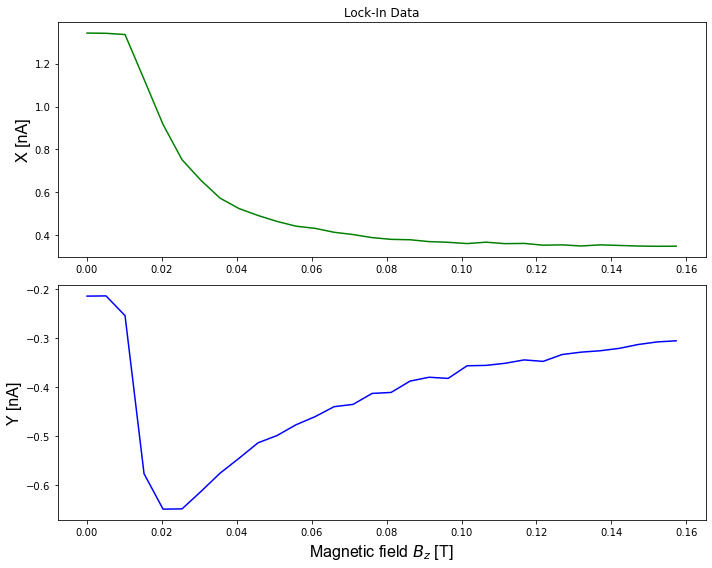

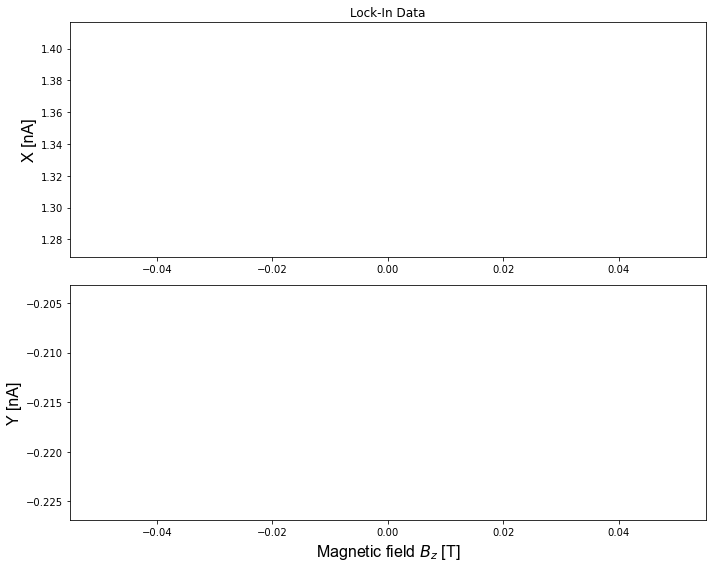

KeyboardInterrupt: 

In [695]:
X = []
Y = []
Field = []

name = "experimental data/Ramping Magnetic field from 0.0T to 0.1928T. BC=BM=20V, TC=TM=0V. Osc_freq = 100003.3Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

final_field = 0.1928                   # in [Tesla]
STEP = 0.005                        # in [Tesla]
field_steps = np.linspace(magnet.get_field(), final_field, int(abs(final_field-magnet.get_field())/STEP+1))

for i in field_steps:
    magnet.ramp_field(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Field.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Field, X, 'g')
    ax[1].plot(Field, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
complete_sound()

In [261]:
Lock_In.get_IntOsc_amp()

[0.025]

# Plotting Sommer-Tanner diagram

In [696]:
xx = []
yy = []

for i in X:
    xx.append(i)
for i in Y:
    yy.append(i)

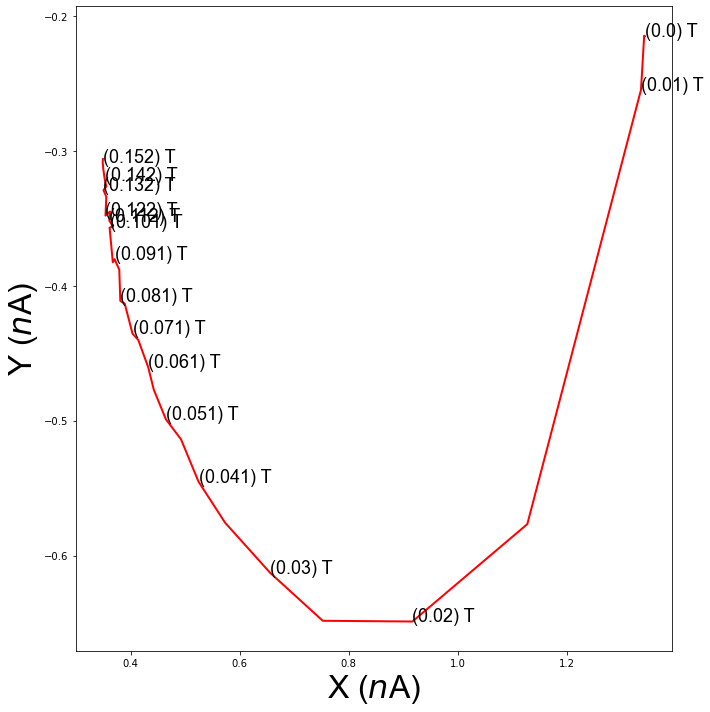

Text(0.5, 1.0, 'Sommer-Tanner diagramm. $B_z$ from 0.0T to 0.05T')

In [697]:
fig, axes = plt.subplots(1,1,figsize=(10, 10))

p = axes.plot(xx, yy, linewidth=2.0, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'X ($n$A)', fontsize=32, **hfont)
axes.set_ylabel(r'Y ($n$A)', fontsize=32, **hfont)

for index, i_x, i_y, i_f in zip(np.arange(0,np.size(xx)), xx, yy, Field):
    if (index%2 ==0): 
        plt.text(i_x, i_y, '({}) T'.format(round(i_f,3)), fontsize=18, **hfont)

plt.show()

axes.set_title('Sommer-Tanner diagramm. $B_z$ from 0.0T to 0.05T', fontsize=24, **hfont)

# Plotting Lockin vs Time

In [180]:
magnet.ramp_field(0.05)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , field_to_freq(magnet.get_field()), 'GHz') 

Current Field:  0.05002 T
Landau frequency:  1.3994399999999998 GHz


In [679]:
start = datetime.datetime.now()
print('Start time of the measurement', start)

Start time of the measurement 2022-03-03 14:50:34.072487


In [678]:
time_constant = 1

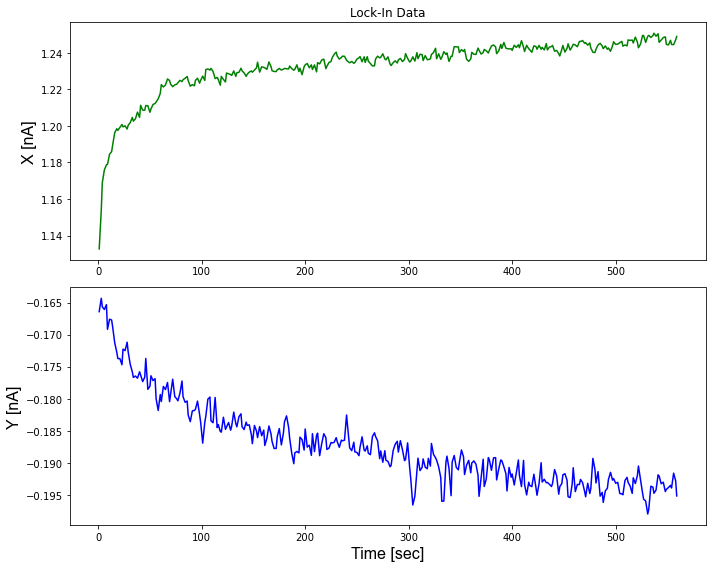

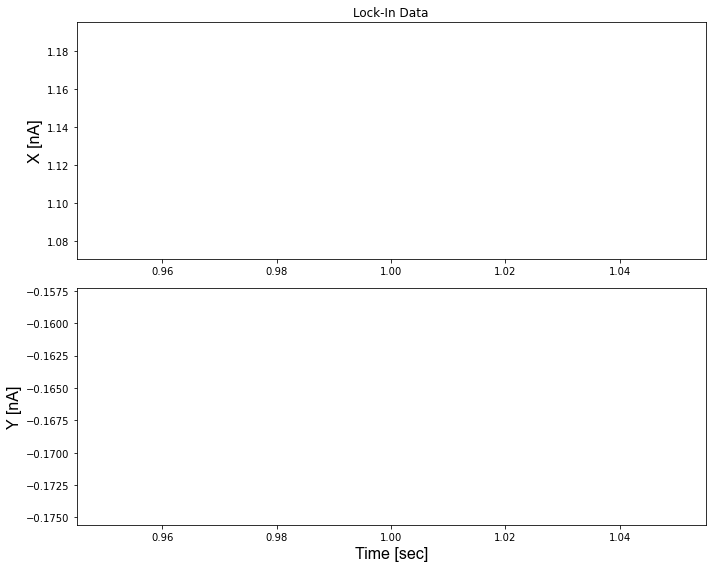

KeyboardInterrupt: 

In [680]:
X = []
Y = []
Time = []

name = "experimental data/Sweep time BC=BM=10V, temp from 200mk to 50mk, Osc_freq = 100003.3Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

final_time = 10000                   # in [sec]
STEP = 1                            # in [sec]
time_steps = np.linspace(0, final_time, int(abs(final_time)/STEP+1))
start = datetime.datetime.now()

for i in time_steps:
    sleep(time_constant)
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Time.append((datetime.datetime.now() - start).seconds)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('Time [sec]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Time, X, 'g')
    ax[1].plot(Time, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
complete_sound()

# Plotting Sommer-Tanner diagram

In [681]:
xx = []
yy = []

for i in X:
    xx.append(i)
for i in Y:
    yy.append(i)

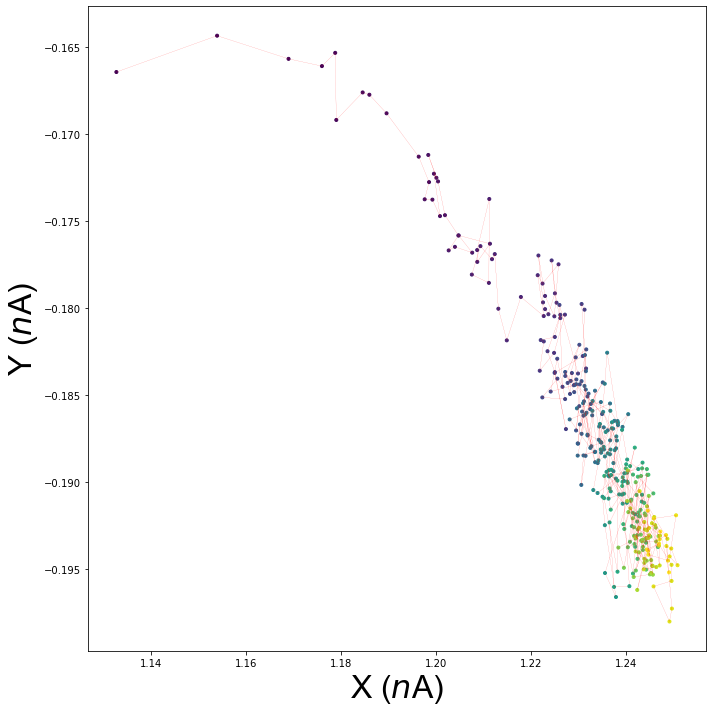

Text(0.5, 1.0, 'Sommer-Tanner diagramm. $T$ from 500mK to 50mK')

In [682]:
fig, axes = plt.subplots(1,1,figsize=(10, 10))

p = axes.scatter(xx, yy, c=Time,  marker='.')
p = axes.plot(xx, yy, linewidth=0.1, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'X ($n$A)', fontsize=32, **hfont)
axes.set_ylabel(r'Y ($n$A)', fontsize=32, **hfont)

plt.show()

axes.set_title('Sommer-Tanner diagramm. $T$ from 500mK to 50mK', fontsize=24, **hfont)

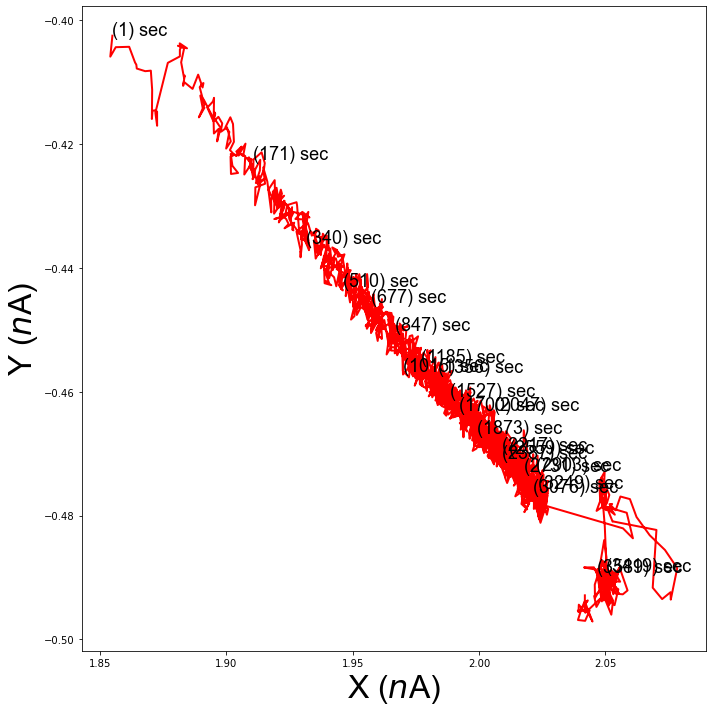

Text(0.5, 1.0, 'Sommer-Tanner diagramm. $T$ from 500mK to 50mK')

In [581]:
fig, axes = plt.subplots(1,1,figsize=(10, 10))

p = axes.plot(xx, yy, linewidth=2.0, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'X ($n$A)', fontsize=32, **hfont)
axes.set_ylabel(r'Y ($n$A)', fontsize=32, **hfont)

for index, i_x, i_y, i_f in zip(np.arange(0,np.size(xx)), xx, yy, Time):
    if (index%100 ==0): 
        plt.text(i_x, i_y, '({}) sec'.format(round(i_f,3)), fontsize=18, **hfont)

plt.show()

axes.set_title('Sommer-Tanner diagramm. $T$ from 500mK to 50mK', fontsize=24, **hfont)

# Lock-in Amp vs Lock-in data

In [323]:
magnet.ramp_field(0.18)

In [332]:
Lock_In.set_IntOsc_frequency(30003.3, 'Hz')

In [369]:
Lock_In.set_IntOsc_amp(0.00)

In [333]:
Lock_In.set_timeconstant(1)

In [366]:
time_constant = Lock_In.get_timeconstant()[0]

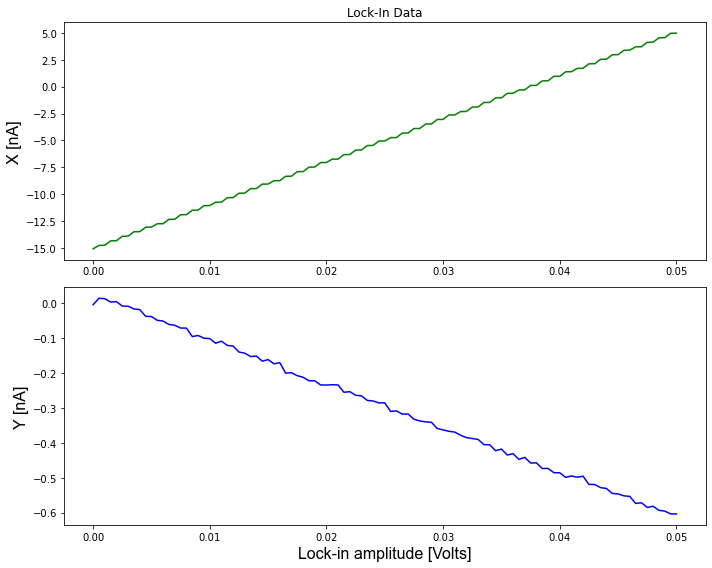

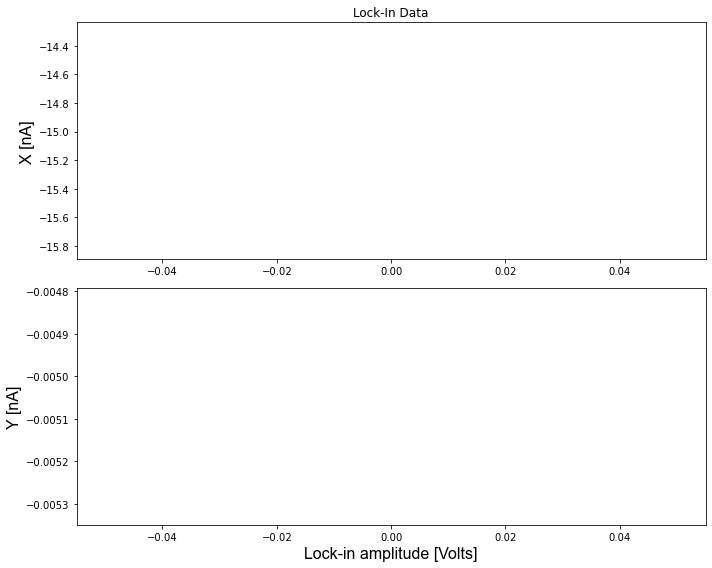

In [368]:
X = []
Y = []
Amp = []

name = "experimental data/Sweep lock-in amp. B_z = 0.18T, Sens = 20nA, BC=BM=20V, TC=TM=-20V, temp from 50mk, Osc_freq = 100003.3Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

initial_amp = int(Lock_In.get_IntOsc_amp()[0])
final_amp = 0.05                         # in [Volts]
STEP = 0.0005                            # in [Volts]
amp_steps = np.linspace(initial_amp, final_amp, int(abs(final_amp-initial_amp)/STEP+1))

for i in amp_steps:
    Lock_In.set_IntOsc_amp(i)
    sleep(time_constant*6)
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Amp.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('Lock-in amplitude [Volts]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Amp, X, 'g')
    ax[1].plot(Amp, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
complete_sound()

# Plotting Lockin vs Voltage

In [407]:
X = []
Y = []
Vlt = []

name = "Ramping Top voltage from -20V to -10V. BC=BM=20V. B_z=0.16T."+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)


plt.setp(ax[0].get_xticklabels(), visible=False)

final_voltage = -10.0
#voltage_steps = np.linspace(current_src_BC.get_voltage(), final_voltage, int(abs(final_voltage-current_src_BC.get_voltage())/0.01+1))
voltage_steps = np.linspace(current_src_TC.get_voltage(), final_voltage, int(abs(final_voltage-current_src_TC.get_voltage())/0.01+1))

for i in voltage_steps:
    #clear_output(wait=True)
    #current_src_BO.set_voltage(i)
    #ramp_3_sourses(i,i,0, sound = False)
    ramp_2_sourses(i,i, sound = False)
    sleep(0.1)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0]))
    Y.append(float(res[1]))
    Vlt.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [V]', fontsize=16, **hfont)
    ax[1].set_xlabel('voltage BC+BM [V]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [V]', fontsize=16, **hfont)
    
    ax[0].plot(Vlt, X, 'g')
    ax[1].plot(Vlt, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
lockin_complete_sound()

Voltage set -1e+01 V
Voltage set -1e+01 V


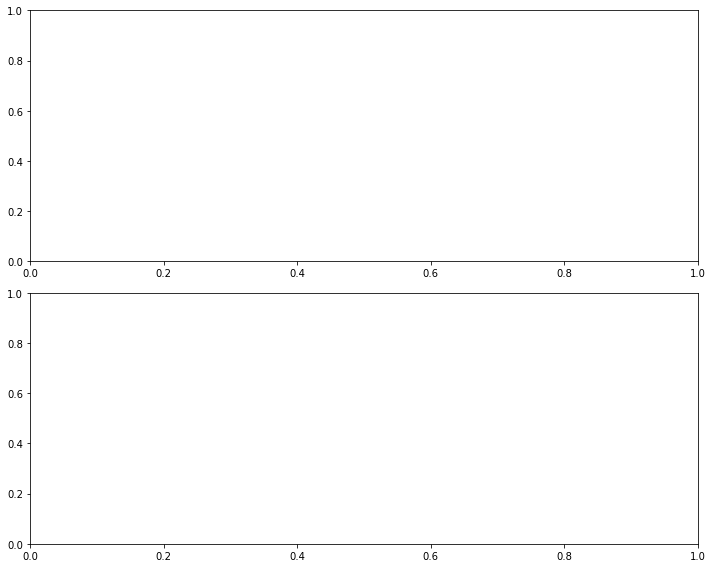

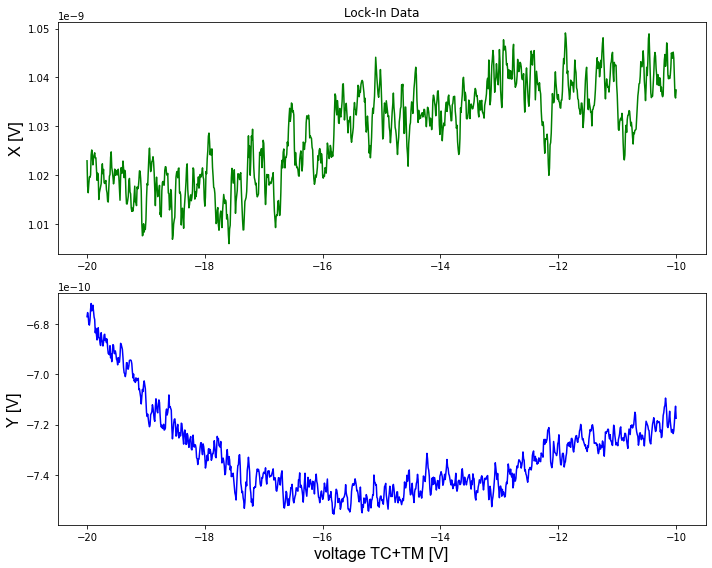

In [408]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

ax[0].set_title('Lock-In Data')
ax[0].set_ylabel('X [V]', fontsize=16, **hfont)
#ax[1].set_xlabel('voltage BC+BM [V]', fontsize=16, **hfont)
ax[1].set_xlabel('voltage TC+TM [V]', fontsize=16, **hfont)
ax[1].set_ylabel('Y [V]', fontsize=16, **hfont)
    
ax[0].plot(Vlt, X, 'g')
ax[1].plot(Vlt, Y, 'b')

# Plotting Sommer-Tanner diagram

In [409]:
xx = []
yy = []

for i in X:
    xx.append(i)
for i in Y:
    yy.append(i)

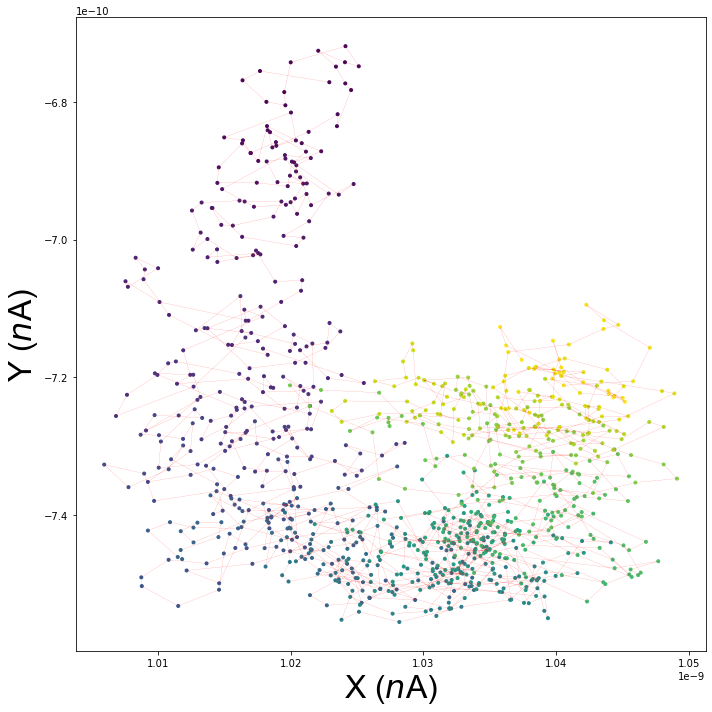

Text(0.5, 1.0, 'Sommer-Tanner diagramm. Voltge from 30V to 50V')

In [410]:
fig, axes = plt.subplots(1,1,figsize=(10, 10))

p = axes.scatter(xx, yy, c=Vlt,  marker='.')
p = axes.plot(xx, yy, linewidth=0.1, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'X ($n$A)', fontsize=32, **hfont)
axes.set_ylabel(r'Y ($n$A)', fontsize=32, **hfont)

plt.show()

axes.set_title('Sommer-Tanner diagramm. Voltge from 30V to 50V', fontsize=24, **hfont)

# Keysight E5071CA Vector network Analyzer

In [582]:
vna = Keysight_E5071C('vna', address = 'VNA')

In [426]:
vna.set_sweep_mode("LIN")

True

In [583]:
vna.set_xlim(5.4e9,5.5e9)
vna.set_nop(201)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(1000)
vna.set_power(-50)

True

In [586]:
x,y = vna.get_tracedata(format = 'AMPPHA')
#x,y = vna.get_tracedata(format = 'REALIMAG')

In [585]:
vna.get_sweep_time()

195.46848

In [435]:
freqs = vna.get_freqpoints()/1e9

In [503]:
def unwrap_phase(datapha):
    for i in range(0, len(datapha)-1):
        if datapha[i+1]-datapha[i] >= numpy.pi:
            datapha[i+1] = datapha[i+1] - 2.*numpy.pi
        elif datapha[i+1]-datapha[i] <= -numpy.pi:
            datapha[i+1] = datapha[i+1] + 2.*numpy.pi
    return datapha

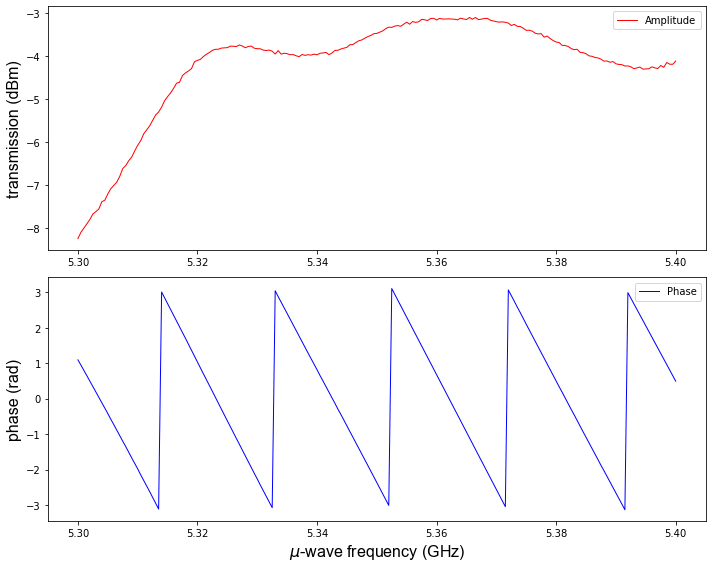

In [587]:
fig, axes = plt.subplots(2,1,figsize=(10, 8))

p = axes[0].plot(freqs, 10*np.log(x), linewidth=1.0, c = 'r', label='Amplitude')
p = axes[1].plot(freqs, y, linewidth=1.0, c = 'b', label='Phase')

#axes.axis('tight')
axes[1].set_xlabel(r'$\mu$-wave frequency (GHz)', fontsize=16, **hfont)

axes[0].set_ylabel(r'transmission (dBm)', fontsize=16, **hfont)
axes[1].set_ylabel(r'phase (rad)', fontsize=16, **hfont)

axes[0].legend()
axes[1].legend()

In [246]:
vna.set_power(-15)

True

In [248]:
x1,y1 = vna.get_tracedata(format = 'AMPPHA')

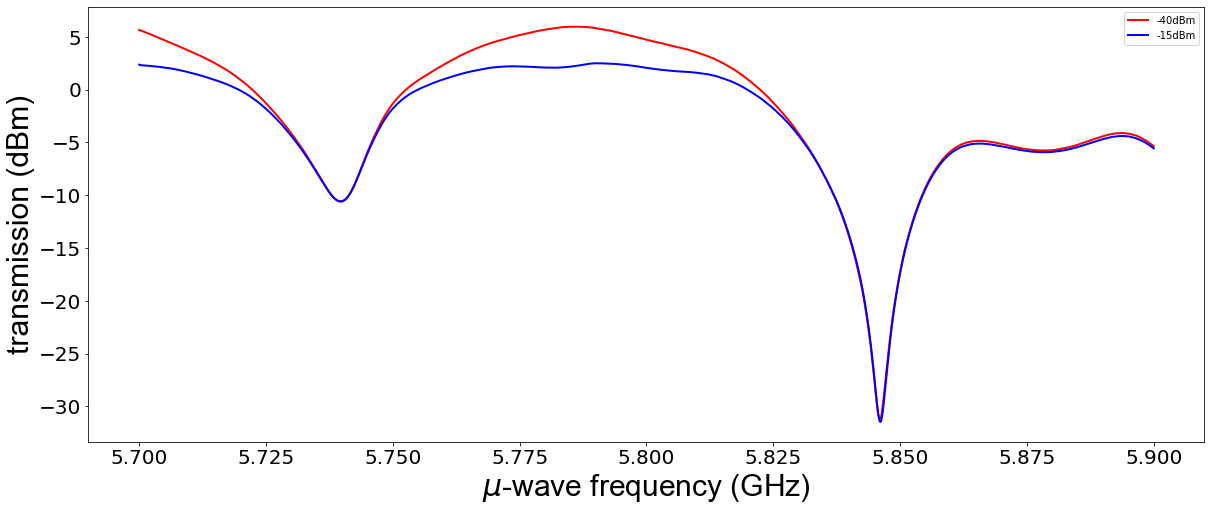

In [255]:
fig, axes = plt.subplots(1,1,figsize=(20, 8))

p = axes.plot(freqs, 10*np.log(x), linewidth=2.0, c = 'r', label='-40dBm')
p = axes.plot(freqs, 10*np.log(x1), linewidth=2.0, c = 'b', label='-15dBm')

#axes.axis('tight')
axes.set_xlabel(r'$\mu$-wave frequency (GHz)', fontsize=30, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel(r'transmission (dBm)', fontsize=30, **hfont)
axes.legend()


# Plotting VNA data vs $\mu$-wave power

In [618]:
magnet.get_field()

0.19399

In [616]:
freq_to_field(5.44)

0.1942857142857143

In [629]:
magnet.ramp_field(0.194)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , field_to_freq(magnet.get_field()), 'GHz') 

Current Field:  0.194 T
Landau frequency:  5.432840000000001 GHz


In [632]:
vna.set_xlim(5.41e9,5.45e9)
vna.set_nop(1001)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(100)
vna.set_power(-70)
sleep_time = vna.get_sweep_time()/1000

In [633]:
x,y = vna.get_tracedata(format = 'AMPPHA')

In [634]:
freq_steps = vna.get_nop()
freq=np.linspace(vna.get_startfreq()/1e9,vna.get_stopfreq()/1e9, freq_steps)       

power_steps = 100
power = np.linspace(vna.get_power(), -20, power_steps)

In [635]:
Transmission = np.zeros((power_steps,freq_steps), dtype=float)
Phase = np.zeros((power_steps,freq_steps), dtype=float)

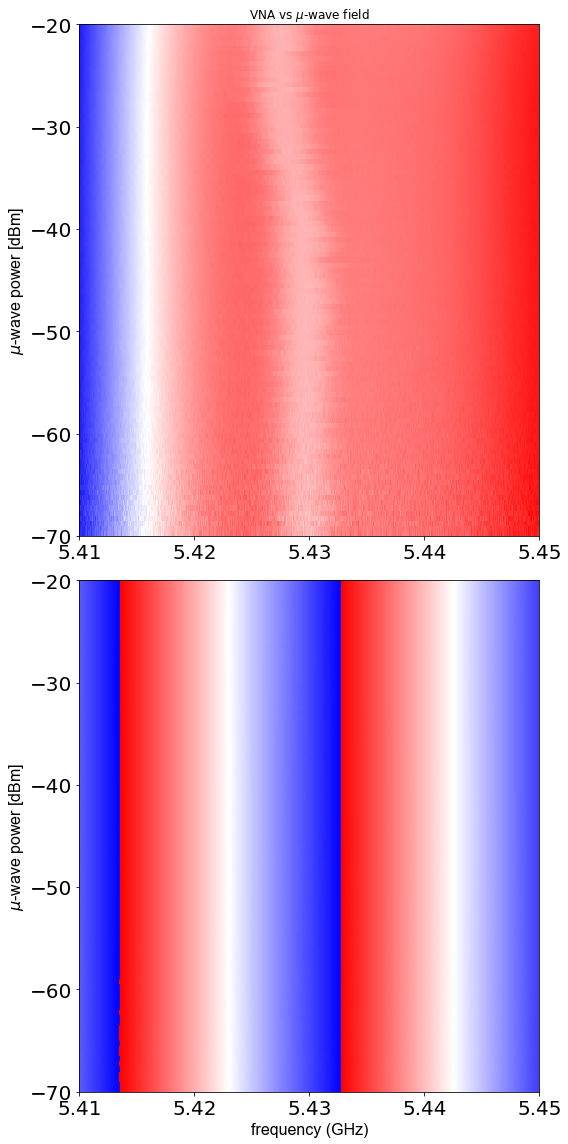

Power:  -70.0 [dBm]


<ipython-input-636-144005110cea>:36: RuntimeWarning: divide by zero encountered in log
  p = axes[0].pcolor(freq, power, 10*np.log(Transmission), cmap=cm.bwr)
<ipython-input-636-144005110cea>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[0].pcolor(freq, power, 10*np.log(Transmission), cmap=cm.bwr)
<ipython-input-636-144005110cea>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[1].pcolor(freq, power, Phase, cmap=cm.bwr)


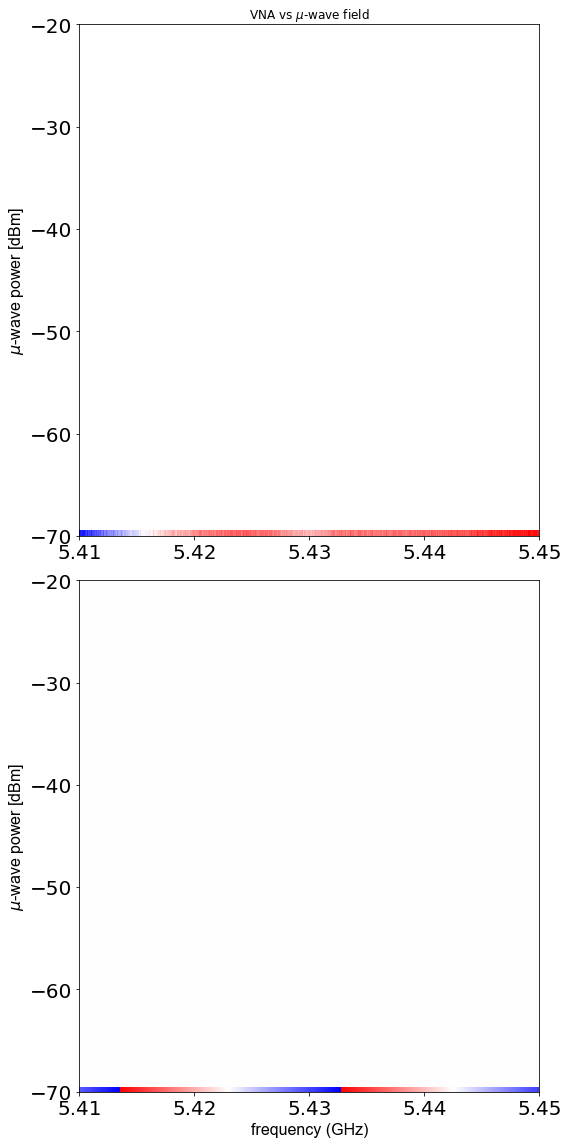

Power:  -69.495 [dBm]
Power:  -68.99 [dBm]
Power:  -68.485 [dBm]
Power:  -67.98 [dBm]
Power:  -67.475 [dBm]
Power:  -66.97 [dBm]
Power:  -66.465 [dBm]
Power:  -65.96 [dBm]
Power:  -65.455 [dBm]
Power:  -64.949 [dBm]
Power:  -64.444 [dBm]
Power:  -63.939 [dBm]
Power:  -63.434 [dBm]
Power:  -62.929 [dBm]
Power:  -62.424 [dBm]
Power:  -61.919 [dBm]
Power:  -61.414 [dBm]
Power:  -60.909 [dBm]
Power:  -60.404 [dBm]
Power:  -59.899 [dBm]
Power:  -59.394 [dBm]
Power:  -58.889 [dBm]
Power:  -58.384 [dBm]
Power:  -57.879 [dBm]
Power:  -57.374 [dBm]
Power:  -56.869 [dBm]
Power:  -56.364 [dBm]
Power:  -55.859 [dBm]
Power:  -55.354 [dBm]
Power:  -54.848 [dBm]
Power:  -54.343 [dBm]
Power:  -53.838 [dBm]
Power:  -53.333 [dBm]
Power:  -52.828 [dBm]
Power:  -52.323 [dBm]
Power:  -51.818 [dBm]
Power:  -51.313 [dBm]
Power:  -50.808 [dBm]
Power:  -50.303 [dBm]
Power:  -49.798 [dBm]
Power:  -49.293 [dBm]
Power:  -48.788 [dBm]
Power:  -48.283 [dBm]
Power:  -47.778 [dBm]
Power:  -47.273 [dBm]
Power:  -46.76

True

In [636]:
name = "experimental data/vna 3Dscan,power sweep from -70dBm to -20dBm. transmission"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, axes = plt.subplots(2,1,figsize=(8, 16))
hfig = display(fig, display_id=True)

for power_id, power_value in enumerate(power):
    print('Power: ', round(power_value,3), '[dBm]')
    
    vna.set_power(power_value)
    sleep(0.3)
    
    x,y = vna.get_tracedata(format = 'AMPPHA')
    sleep(sleep_time)
    sleep(0.2)
    
    file.write(f"{power_value}\n")
    file.write(f"{x}\n")
    file.write(f"{y}\n")
    
    Transmission[power_id] = x 
    Phase[power_id] = y 

    # dynamic plot
    axes[0].cla()
    axes[1].cla()
    axes[0].set_title('VNA vs $\mu$-wave field')
    axes[0].tick_params(axis='x', labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    axes[1].tick_params(axis='x', labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    axes[0].set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
    axes[1].set_xlabel('frequency (GHz)', fontsize=16, **hfont)
    axes[1].set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
    
    p = axes[0].pcolor(freq, power, 10*np.log(Transmission), cmap=cm.bwr)
    #cb = fig.colorbar(p, ax=axes[0])
    #cb.set_label(r'transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
    #cb.ax.tick_params(labelsize=18)
    
    p = axes[1].pcolor(freq, power, Phase, cmap=cm.bwr)
    #cb = fig.colorbar(p, ax=axes[1])
    #cb.set_label(r'phase (rad)', labelpad=20, rotation=270, fontsize=24, **hfont)
    #cb.ax.tick_params(labelsize=18)
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
vna.set_power(-70)

In [637]:
file.close()

# substract the background

In [640]:
Transmission_nobg = np.zeros((power_steps,freq_steps), dtype=float)
for i_id,i_value in enumerate(Transmission_nobg):
    Transmission_nobg[i_id]=10*np.log(Transmission[i_id])-10*np.log(Transmission[0])

<ipython-input-641-1c9123f86e2b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, power, Transmission_nobg, cmap=cm.bwr)


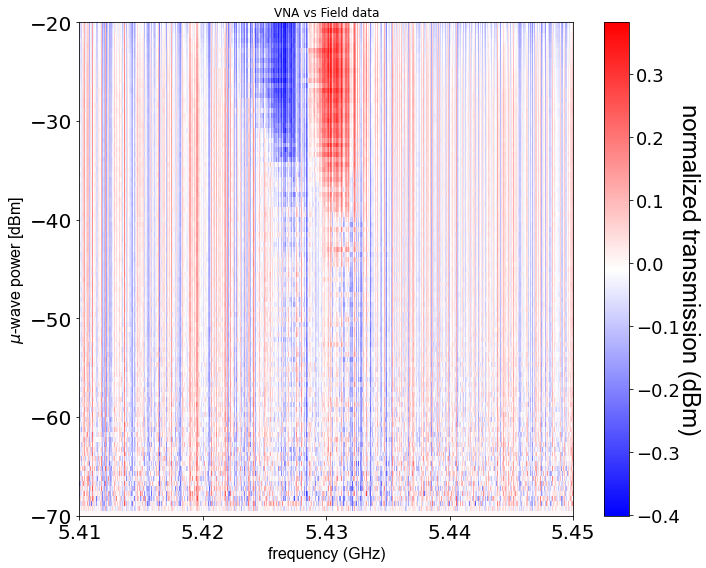

In [641]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

p = axes.pcolor(freq, power, Transmission_nobg, cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# Plotting VNA data vs Magnetic field

In [594]:
magnet.get_field()

0.19277

In [589]:
freq_to_field(np.array([5.4,5.5]))

array([0.19285714, 0.19642857])

In [595]:
magnet.ramp_field(0.1928)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , round(field_to_freq(magnet.get_field()),4), 'GHz') 

Current Field:  0.19281 T
Landau frequency:  5.3984 GHz


In [598]:
vna.set_xlim(5.4e9,5.5e9)
vna.set_nop(501)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(100)
vna.set_power(-30)
sleep_time = vna.get_sweep_time()/1000

In [599]:
x,y = vna.get_tracedata(format = 'AMPPHA')

In [601]:
freq_steps = vna.get_nop()
freq=np.linspace(vna.get_startfreq()/1e9,vna.get_stopfreq()/1e9, freq_steps)       

field_steps = 100
field = np.linspace(magnet.get_field(), freq_to_field(5.5), field_steps)

In [602]:
Transmission = np.zeros((field_steps,freq_steps), dtype=float)
Phase = np.zeros((field_steps,freq_steps), dtype=float)

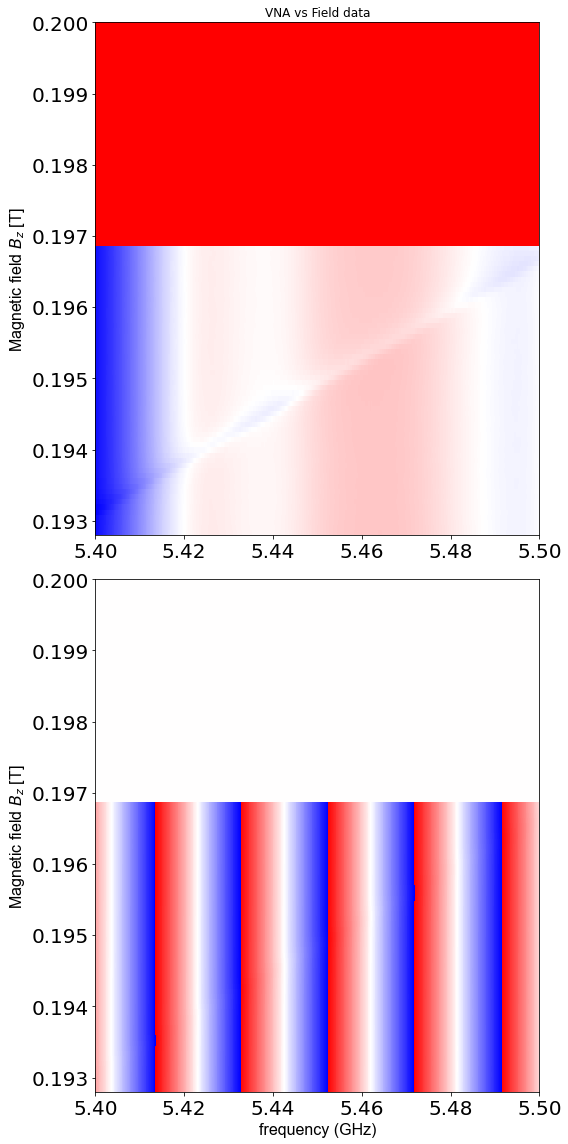

Field:  0.1928 [T]


<ipython-input-603-5bc424282980>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[0].pcolor(freq, field, Transmission, cmap=cm.bwr)
<ipython-input-603-5bc424282980>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[1].pcolor(freq, field, Phase, cmap=cm.bwr)


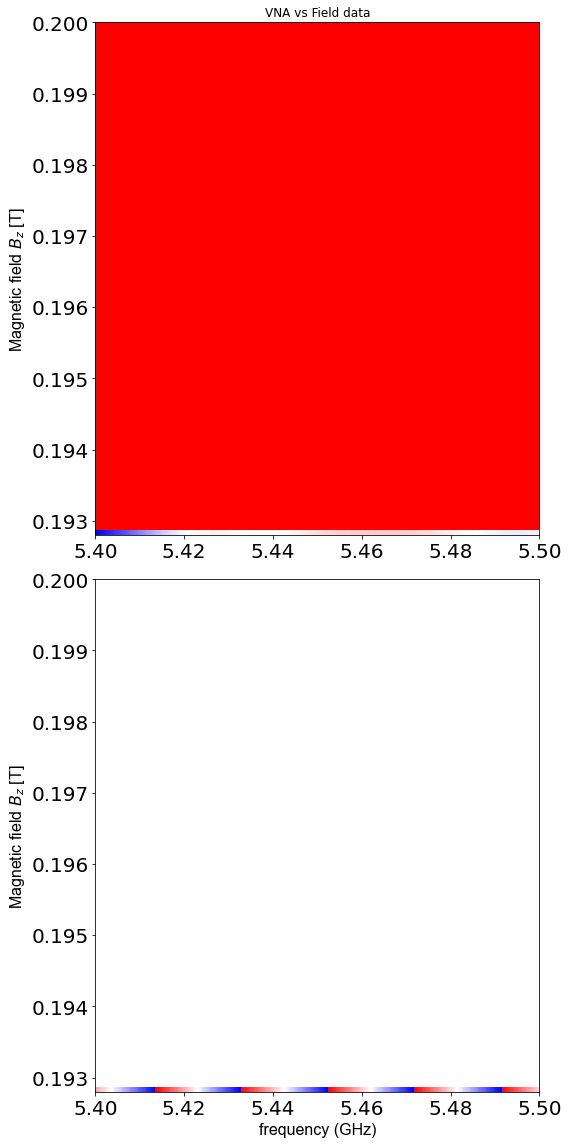

Field:  0.1929 [T]
Field:  0.1929 [T]
Field:  0.193 [T]
Field:  0.1931 [T]
Field:  0.1932 [T]
Field:  0.1932 [T]
Field:  0.1933 [T]
Field:  0.1934 [T]
Field:  0.1935 [T]
Field:  0.1935 [T]
Field:  0.1936 [T]
Field:  0.1937 [T]
Field:  0.1937 [T]
Field:  0.1938 [T]
Field:  0.1939 [T]
Field:  0.194 [T]
Field:  0.194 [T]
Field:  0.1941 [T]
Field:  0.1942 [T]
Field:  0.1943 [T]
Field:  0.1943 [T]
Field:  0.1944 [T]
Field:  0.1945 [T]
Field:  0.1945 [T]
Field:  0.1946 [T]
Field:  0.1947 [T]
Field:  0.1948 [T]
Field:  0.1948 [T]
Field:  0.1949 [T]
Field:  0.195 [T]
Field:  0.1951 [T]
Field:  0.1951 [T]
Field:  0.1952 [T]
Field:  0.1953 [T]
Field:  0.1953 [T]
Field:  0.1954 [T]
Field:  0.1955 [T]
Field:  0.1956 [T]
Field:  0.1956 [T]
Field:  0.1957 [T]
Field:  0.1958 [T]
Field:  0.1959 [T]
Field:  0.1959 [T]
Field:  0.196 [T]
Field:  0.1961 [T]
Field:  0.1961 [T]
Field:  0.1962 [T]
Field:  0.1963 [T]
Field:  0.1964 [T]
Field:  0.1964 [T]
Field:  0.1965 [T]
Field:  0.1966 [T]
Field:  0.1967 [T

KeyboardInterrupt: 

In [603]:
name = "experimental data/vna 3Dscan,Ramping Magnetic field from 0.192, 0.196T. -30dBm, Transmission "+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, axes = plt.subplots(2,1,figsize=(8, 16))
hfig = display(fig, display_id=True)

for field_id, field_value in enumerate(field):
    print('Field: ', round(field_value,4), '[T]')
    
    magnet.ramp_field(field_value)
    sleep(0.5)
    
    x,y = vna.get_tracedata(format = 'AMPPHA')
    sleep(sleep_time)
    sleep(0.3)

    file.write(f"{field_value}\n")
    file.write(f"{x}\n")
    file.write(f"{y}\n")
    
    Transmission[field_id] = 10*np.log(x) 
    Phase[field_id] = y 

    # dynamic plot
    axes[0].cla()
    axes[1].cla()
    axes[0].set_title('VNA vs Field data')
    axes[0].tick_params(axis='x', labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    axes[1].tick_params(axis='x', labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    axes[0].set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    axes[1].set_xlabel('frequency (GHz)', fontsize=16, **hfont)
    axes[1].set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    
    p = axes[0].pcolor(freq, field, Transmission, cmap=cm.bwr)
    p = axes[1].pcolor(freq, field, Phase, cmap=cm.bwr)

    
    hfig.update(fig)
    plt.pause(0.1)
    
#cb = fig.colorbar(p, ax=axes[0])
#cb.set_label(r'transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
#cb.ax.tick_params(labelsize=18)
#cb = fig.colorbar(p, ax=axes[1])
#cb.set_label(r'phase (rad)', labelpad=20, rotation=270, fontsize=24, **hfont)
#cb.ax.tick_params(labelsize=18)
    
file.close()
complete_sound()

<ipython-input-611-26343a8086fe>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, field[0:50], Transmission[0:50], cmap=cm.bwr)


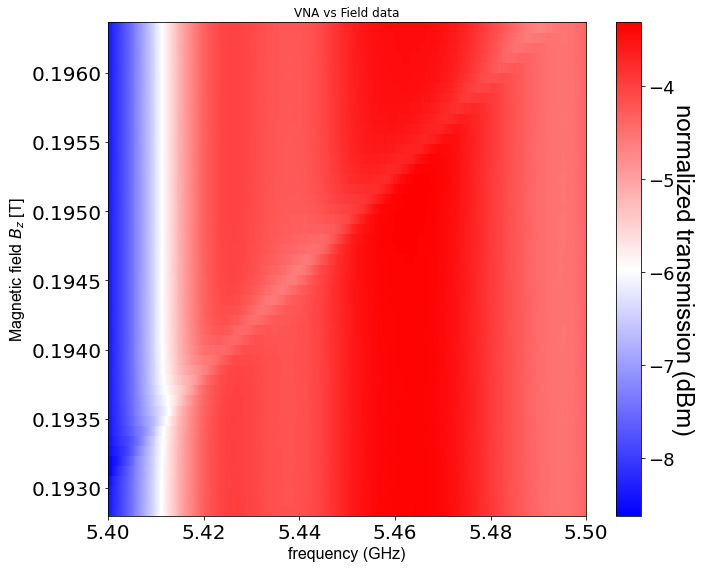

In [611]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

#axes.set_ylim(0.211,0.2175)

p = axes.pcolor(freq, field[0:50], Transmission[0:50], cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# substract the background

In [612]:
Transmission_nobg = np.zeros((field_steps,freq_steps), dtype=float)
for i_id,i_value in enumerate(Transmission_nobg):
    Transmission_nobg[i_id]=Transmission[i_id] - Transmission[1]

In [606]:
#Transmission_nobg[0]=Transmission_nobg[1]

<ipython-input-614-86bf4a3c32a7>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, field[0:50], Transmission_nobg[0:50], cmap=cm.bwr)


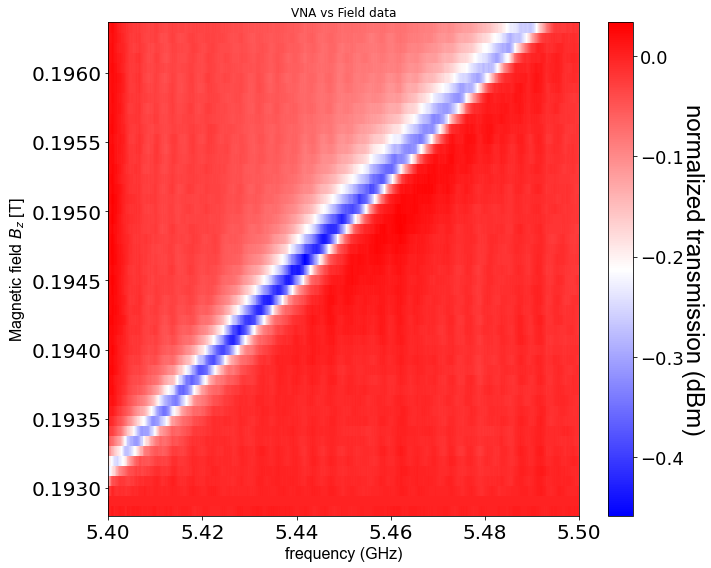

In [614]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

p = axes.pcolor(freq, field[0:50], Transmission_nobg[0:50], cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# Vna scan vs voltage sweep

In [642]:
vna.set_xlim(5.42e9,5.44e9)
vna.set_nop(201)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(1000)
vna.set_power(-50)

True

In [644]:
magnet.ramp_field(0.1875)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , round(field_to_freq(magnet.get_field()),4), 'GHz') 

Current Field:  0.18751 T
Landau frequency:  5.2506 GHz


In [646]:
x_bg,y_bg = vna.get_tracedata(format = 'AMPPHA')

In [647]:
magnet.ramp_field(0.1928)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , round(field_to_freq(magnet.get_field()),4), 'GHz') 

Current Field:  0.1928 T
Landau frequency:  5.3981 GHz


In [648]:
x,y = vna.get_tracedata(format = 'AMPPHA')
#x,y = vna.get_tracedata(format = 'REALIMAG')

In [649]:
vna.get_sweep_time()

194.43936

In [650]:
freqs = vna.get_freqpoints()/1e9

Text(0, 0.5, 'transmission (dBm)')

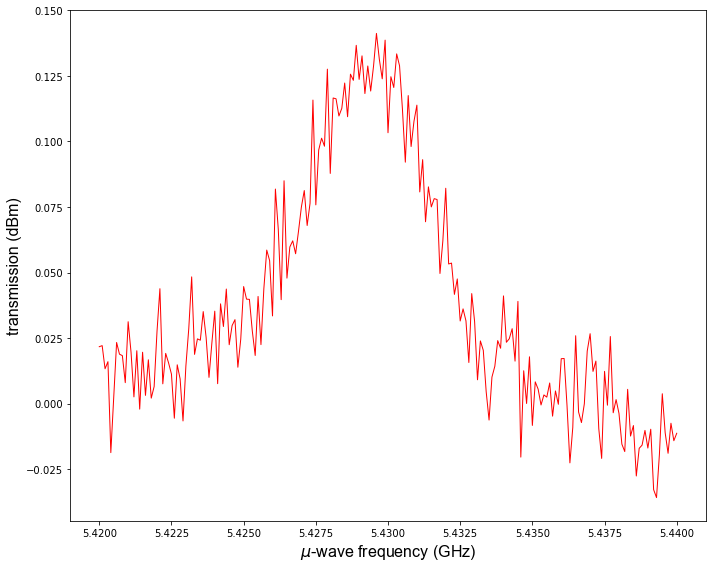

In [651]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

#p = axes.plot(freqs, 10*np.log(x), linewidth=1.0, c = 'r', label='Amplitude')
#p = axes.plot(freqs, 10*np.log(x_bg), linewidth=1.0, c = 'b', label='Amplitude')

p = axes.plot(freqs, 10*np.log(x)-10*np.log(x_bg), linewidth=1.0, c = 'r', label='Amplitude')

#axes.axis('tight')
axes.set_xlabel(r'$\mu$-wave frequency (GHz)', fontsize=16, **hfont)
axes.set_ylabel(r'transmission (dBm)', fontsize=16, **hfont)

In [531]:
ramp_3_sourses(10,10,0)

Voltage set 1e+01 V
Voltage set 1e+01 V


In [667]:
freq_steps = vna.get_nop()
freq=np.linspace(vna.get_startfreq()/1e9,vna.get_stopfreq()/1e9, freq_steps)       

voltage_steps = 100
voltage = np.linspace(current_src_BC.get_voltage(), 1, voltage_steps)
#voltage = np.linspace(current_src_TC.get_voltage(), -20, voltage_steps)

In [669]:
Transmission = np.zeros((voltage_steps,freq_steps), dtype=float)
Phase = np.zeros((voltage_steps,freq_steps), dtype=float)

Voltage set 1e+00 V
Voltage set 1e+00 V


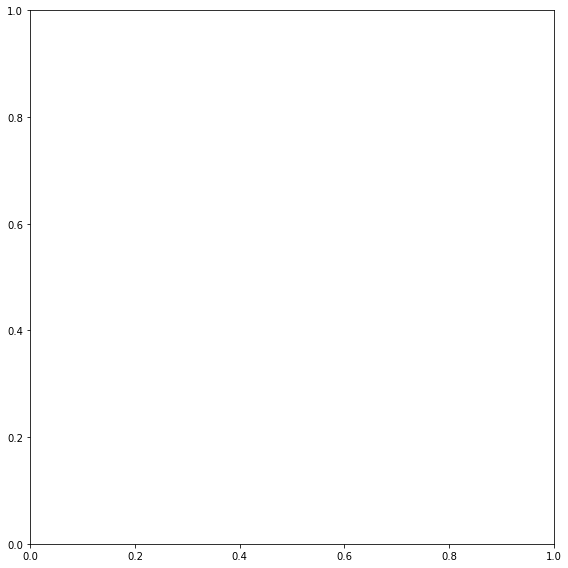

In [670]:
name = "experimental data/vna 3Dscan,voltage sweep from 20V to 1V. transmission"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, axes = plt.subplots(1,1,figsize=(8, 8))
hfig = display(fig, display_id=True)

for voltage_id, voltage_value in enumerate(voltage):
    print('Voltage: ', round(voltage_value,3), '[dBm]')
    
    ramp_3_sourses(voltage_value,voltage_value,0, sound = False)
    #ramp_2_sourses(voltage_value,voltage_value, sound = False)
    sleep(0.3)
    
    x,y = vna.get_tracedata(format = 'AMPPHA')
    sleep(sleep_time)
    sleep(0.2)
    
    file.write(f"{voltage_value}\n")
    file.write(f"{x}\n")
    file.write(f"{y}\n")
    
    Transmission[voltage_id] = x 
    Phase[voltage_id] = y 
    
file.close()

In [671]:
file.close()

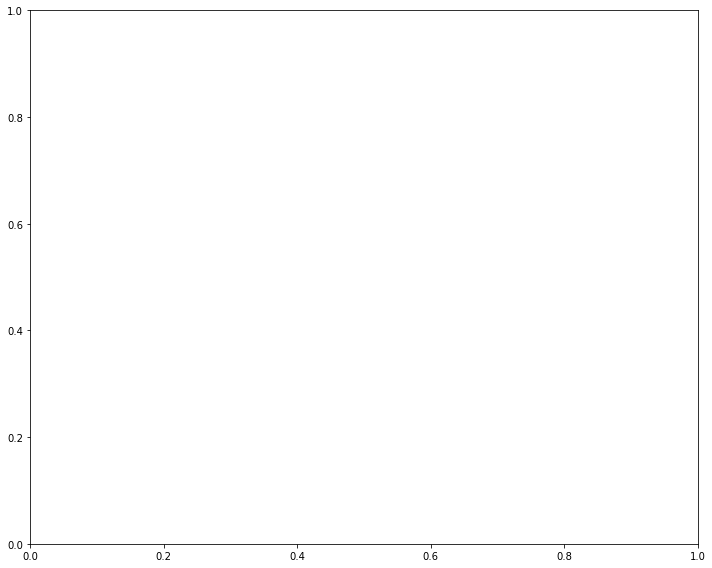

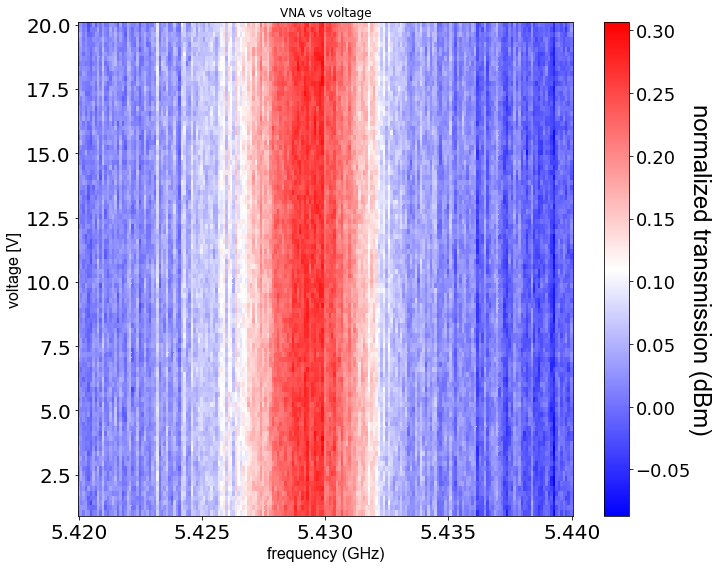

In [672]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))
hfig = display(fig, display_id=False)

axes.set_title('VNA vs voltage')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)
axes.set_ylabel('voltage [V]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

p = axes.pcolor(freq, voltage, 10*np.log(Transmission)-10*np.log(x_bg),shading='auto', cmap=cm.bwr)
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# Lab brick test

In [700]:
get_labbricks()

{1: {'name': 'LMS-183DX', 'serial_number': 27937}}

In [701]:
lo1 = Labbrick(name='LMS-183DX', serial=27937)

In [702]:
lo1.set_power(-20)
lo1.get_power()

-20.0

In [703]:
lo1.set_status(False)
lo1.set_power(-30)
lo1.set_frequency(6.003e9)

True

In [704]:
lo1.get_frequency()

6003000000.0

In [705]:
lo1.set_status(False)

True

In [706]:
np.array([9.16,14.17])*12

array([109.92, 170.04])

In [308]:
160/12

13.333333333333334

# Plotting Lock-in data vs lab-brick frequency (mm-waves)

In [707]:
print ("Landau frequency is: ", field_to_freq(magnet.get_field()), "[GHz]")

Landau frequency is:  4.54524 [GHz]


In [719]:
magnet.ramp_field(0.00)

In [720]:
get_mult_freq(155e9)

12916666666.666666

In [721]:
lo1.set_power(0)                                       #for the mm-wave generation
lo1.set_frequency(get_mult_freq(110e9))
lo1.set_status(False)


#lo1.set_power(-30)                                      #for the Landau levels excitation
#lo1.set_frequency(5.8e9)
#lo1.set_status(False)

True

In [722]:
time_constant = 1.0

In [723]:
lo1.set_status(False)

True

In [726]:
lo1.set_status(True)

True

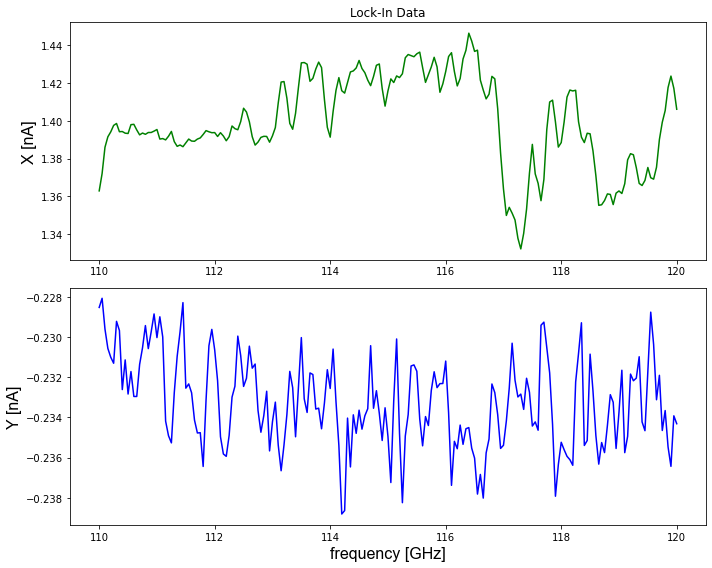

IntProgress(value=0, max=201)

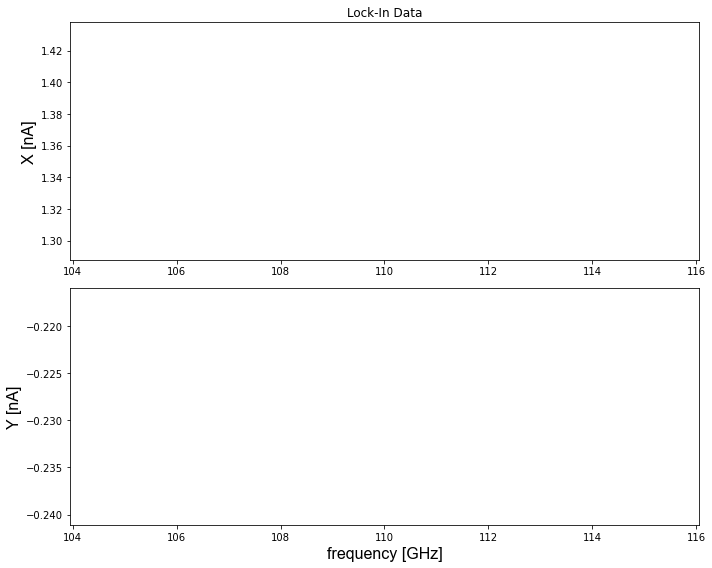

In [727]:
X = []
Y = []
Frequency = []

name = "Sweep mm-wave freq from 110GHZ to 120GHz. P=1. Osc_freq = 100033Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

Steps = 201
freq_steps = np.linspace(get_mult_freq(110e9), get_mult_freq(120e9),Steps)
f = IntProgress(min=0, max=Steps)                                            # instantiate the bar
display(f)                                                                   # display the bar

for i in freq_steps:
    lo1.set_frequency(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Frequency.append(get_der_freq(i)/1e9)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('frequency [GHz]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Frequency, X, 'g')
    ax[1].plot(Frequency, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    f.value += 1
    
lo1.set_status(False)
file.close()
complete_sound()

# Plotting Lock-in data vs BC$\&$BM Voltage (mm-waves frequency is fixed)

In [728]:
lo1.set_power(0)
lo1.set_frequency(get_mult_freq(140e9))
lo1.set_status(False)

True

In [732]:
lo1.set_status(True)

True

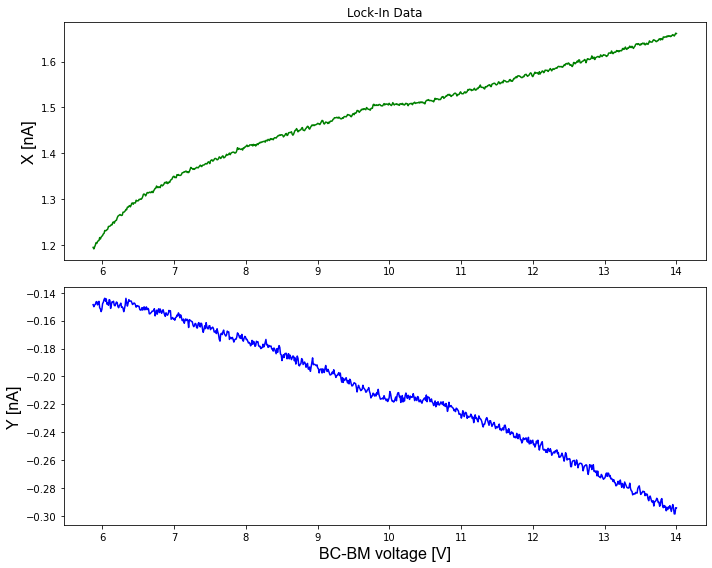

IntProgress(value=0, max=801)

Voltage set 5.87e+00 V
Voltage set 5.87e+00 V


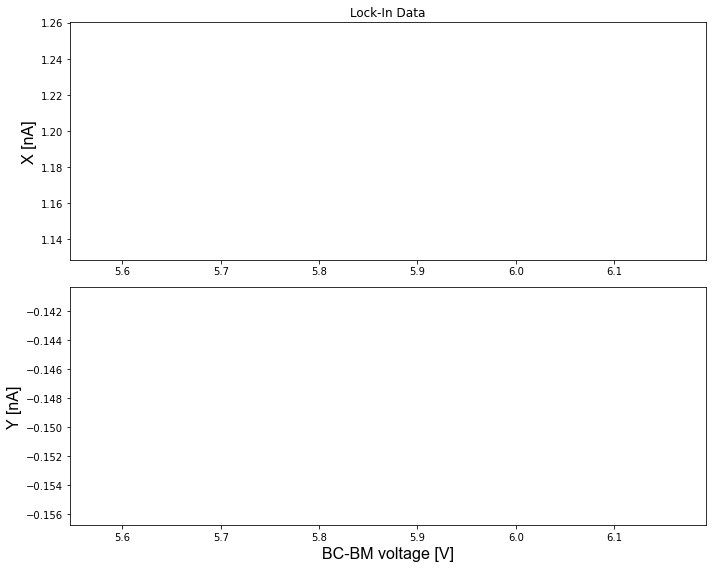

Voltage set 5.880162e+00 V
Voltage set 5.880162e+00 V
Voltage set 5.890325e+00 V
Voltage set 5.890325e+00 V
Voltage set 5.900487e+00 V
Voltage set 5.900487e+00 V
Voltage set 5.91065e+00 V
Voltage set 5.91065e+00 V
Voltage set 5.920813e+00 V
Voltage set 5.920813e+00 V
Voltage set 5.930975e+00 V
Voltage set 5.930975e+00 V
Voltage set 5.941137e+00 V
Voltage set 5.941137e+00 V
Voltage set 5.9513e+00 V
Voltage set 5.9513e+00 V
Voltage set 5.961462e+00 V
Voltage set 5.961462e+00 V
Voltage set 5.971625e+00 V
Voltage set 5.971625e+00 V
Voltage set 5.981788e+00 V
Voltage set 5.981788e+00 V
Voltage set 5.99195e+00 V
Voltage set 5.99195e+00 V
Voltage set 6.002112e+00 V
Voltage set 6.002112e+00 V
Voltage set 6.012275e+00 V
Voltage set 6.012275e+00 V
Voltage set 6.022437e+00 V
Voltage set 6.022437e+00 V
Voltage set 6.0326e+00 V
Voltage set 6.0326e+00 V
Voltage set 6.042763e+00 V
Voltage set 6.042763e+00 V
Voltage set 6.052925e+00 V
Voltage set 6.052925e+00 V
Voltage set 6.063087e+00 V
Voltage set 6

Voltage set 7.445187e+00 V
Voltage set 7.445187e+00 V
Voltage set 7.45535e+00 V
Voltage set 7.45535e+00 V
Voltage set 7.465512e+00 V
Voltage set 7.465512e+00 V
Voltage set 7.475675e+00 V
Voltage set 7.475675e+00 V
Voltage set 7.485837e+00 V
Voltage set 7.485837e+00 V
Voltage set 7.496e+00 V
Voltage set 7.496e+00 V
Voltage set 7.506163e+00 V
Voltage set 7.506163e+00 V
Voltage set 7.516325e+00 V
Voltage set 7.516325e+00 V
Voltage set 7.526487e+00 V
Voltage set 7.526487e+00 V
Voltage set 7.53665e+00 V
Voltage set 7.53665e+00 V
Voltage set 7.546812e+00 V
Voltage set 7.546812e+00 V
Voltage set 7.556975e+00 V
Voltage set 7.556975e+00 V
Voltage set 7.567137e+00 V
Voltage set 7.567137e+00 V
Voltage set 7.5773e+00 V
Voltage set 7.5773e+00 V
Voltage set 7.587462e+00 V
Voltage set 7.587462e+00 V
Voltage set 7.597625e+00 V
Voltage set 7.597625e+00 V
Voltage set 7.607787e+00 V
Voltage set 7.607787e+00 V
Voltage set 7.61795e+00 V
Voltage set 7.61795e+00 V
Voltage set 7.628113e+00 V
Voltage set 7.628

Voltage set 9.010212e+00 V
Voltage set 9.010212e+00 V
Voltage set 9.020375e+00 V
Voltage set 9.020375e+00 V
Voltage set 9.030537e+00 V
Voltage set 9.030537e+00 V
Voltage set 9.0407e+00 V
Voltage set 9.0407e+00 V
Voltage set 9.050862e+00 V
Voltage set 9.050862e+00 V
Voltage set 9.061025e+00 V
Voltage set 9.061025e+00 V
Voltage set 9.071187e+00 V
Voltage set 9.071187e+00 V
Voltage set 9.08135e+00 V
Voltage set 9.08135e+00 V
Voltage set 9.091513e+00 V
Voltage set 9.091513e+00 V
Voltage set 9.101675e+00 V
Voltage set 9.101675e+00 V
Voltage set 9.111838e+00 V
Voltage set 9.111838e+00 V
Voltage set 9.122e+00 V
Voltage set 9.122e+00 V
Voltage set 9.132162e+00 V
Voltage set 9.132162e+00 V
Voltage set 9.142325e+00 V
Voltage set 9.142325e+00 V
Voltage set 9.152487e+00 V
Voltage set 9.152487e+00 V
Voltage set 9.16265e+00 V
Voltage set 9.16265e+00 V
Voltage set 9.172812e+00 V
Voltage set 9.172812e+00 V
Voltage set 9.182975e+00 V
Voltage set 9.182975e+00 V
Voltage set 9.193137e+00 V
Voltage set 9.1

Voltage set 1.057524e+01 V
Voltage set 1.057524e+01 V
Voltage set 1.05854e+01 V
Voltage set 1.05854e+01 V
Voltage set 1.059556e+01 V
Voltage set 1.059556e+01 V
Voltage set 1.060572e+01 V
Voltage set 1.060572e+01 V
Voltage set 1.061589e+01 V
Voltage set 1.061589e+01 V
Voltage set 1.062605e+01 V
Voltage set 1.062605e+01 V
Voltage set 1.063621e+01 V
Voltage set 1.063621e+01 V
Voltage set 1.064637e+01 V
Voltage set 1.064637e+01 V
Voltage set 1.065654e+01 V
Voltage set 1.065654e+01 V
Voltage set 1.06667e+01 V
Voltage set 1.06667e+01 V
Voltage set 1.067686e+01 V
Voltage set 1.067686e+01 V
Voltage set 1.068702e+01 V
Voltage set 1.068702e+01 V
Voltage set 1.069719e+01 V
Voltage set 1.069719e+01 V
Voltage set 1.070735e+01 V
Voltage set 1.070735e+01 V
Voltage set 1.071751e+01 V
Voltage set 1.071751e+01 V
Voltage set 1.072767e+01 V
Voltage set 1.072767e+01 V
Voltage set 1.073784e+01 V
Voltage set 1.073784e+01 V
Voltage set 1.0748e+01 V
Voltage set 1.0748e+01 V
Voltage set 1.075816e+01 V
Voltage s

Voltage set 1.21301e+01 V
Voltage set 1.21301e+01 V
Voltage set 1.214026e+01 V
Voltage set 1.214026e+01 V
Voltage set 1.215042e+01 V
Voltage set 1.215042e+01 V
Voltage set 1.216059e+01 V
Voltage set 1.216059e+01 V
Voltage set 1.217075e+01 V
Voltage set 1.217075e+01 V
Voltage set 1.218091e+01 V
Voltage set 1.218091e+01 V
Voltage set 1.219107e+01 V
Voltage set 1.219107e+01 V
Voltage set 1.220124e+01 V
Voltage set 1.220124e+01 V
Voltage set 1.22114e+01 V
Voltage set 1.22114e+01 V
Voltage set 1.222156e+01 V
Voltage set 1.222156e+01 V
Voltage set 1.223172e+01 V
Voltage set 1.223172e+01 V
Voltage set 1.224189e+01 V
Voltage set 1.224189e+01 V
Voltage set 1.225205e+01 V
Voltage set 1.225205e+01 V
Voltage set 1.226221e+01 V
Voltage set 1.226221e+01 V
Voltage set 1.227237e+01 V
Voltage set 1.227237e+01 V
Voltage set 1.228254e+01 V
Voltage set 1.228254e+01 V
Voltage set 1.22927e+01 V
Voltage set 1.22927e+01 V
Voltage set 1.230286e+01 V
Voltage set 1.230286e+01 V
Voltage set 1.231302e+01 V
Voltage

Voltage set 1.368496e+01 V
Voltage set 1.368496e+01 V
Voltage set 1.369512e+01 V
Voltage set 1.369512e+01 V
Voltage set 1.370529e+01 V
Voltage set 1.370529e+01 V
Voltage set 1.371545e+01 V
Voltage set 1.371545e+01 V
Voltage set 1.372561e+01 V
Voltage set 1.372561e+01 V
Voltage set 1.373577e+01 V
Voltage set 1.373577e+01 V
Voltage set 1.374594e+01 V
Voltage set 1.374594e+01 V
Voltage set 1.37561e+01 V
Voltage set 1.37561e+01 V
Voltage set 1.376626e+01 V
Voltage set 1.376626e+01 V
Voltage set 1.377642e+01 V
Voltage set 1.377642e+01 V
Voltage set 1.378659e+01 V
Voltage set 1.378659e+01 V
Voltage set 1.379675e+01 V
Voltage set 1.379675e+01 V
Voltage set 1.380691e+01 V
Voltage set 1.380691e+01 V
Voltage set 1.381707e+01 V
Voltage set 1.381707e+01 V
Voltage set 1.382724e+01 V
Voltage set 1.382724e+01 V
Voltage set 1.38374e+01 V
Voltage set 1.38374e+01 V
Voltage set 1.384756e+01 V
Voltage set 1.384756e+01 V
Voltage set 1.385772e+01 V
Voltage set 1.385772e+01 V
Voltage set 1.386789e+01 V
Volta

In [733]:
X = []
Y = []
Voltage = []

name = "Sweep BC-BM voltage from 6V to 14V. mm_freq = 140GHz P=2. Osc_freq = 100033Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

Steps = 801
voltage_steps = np.linspace(5.87, 14,Steps)
f = IntProgress(min=0, max=Steps)                                            # instantiate the bar
display(f)                                                                   # display the bar

for i in voltage_steps:
    current_src_BC.set_voltage(i)
    current_src_BM.set_voltage(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Voltage.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('BC-BM voltage [V]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Voltage, X, 'g')
    ax[1].plot(Voltage, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    f.value += 1
    
lo1.set_status(False)
file.close()
complete_sound()

Parts

Sweeps

In [5]:
current_src_5 = Yokogawa_GS210(address='gs210_5')
current_src_5.set_src_mode_volt()                                   # switch Yokogawa to the Voltage mode
current_src_5.set_range(10)                                         # set voltage Source Range
current_src_5.set_voltage_limits(minvoltage = -5, maxvoltage = 5)   # set the +- maximum voltage ranges in [volts]
current_src_5.set_voltage(-1)

Voltage set -1e+00 V


True

In [8]:
voltages = np.linspace(-1, 1, 11)

Started at:  Jan 24 2022 18:41:19


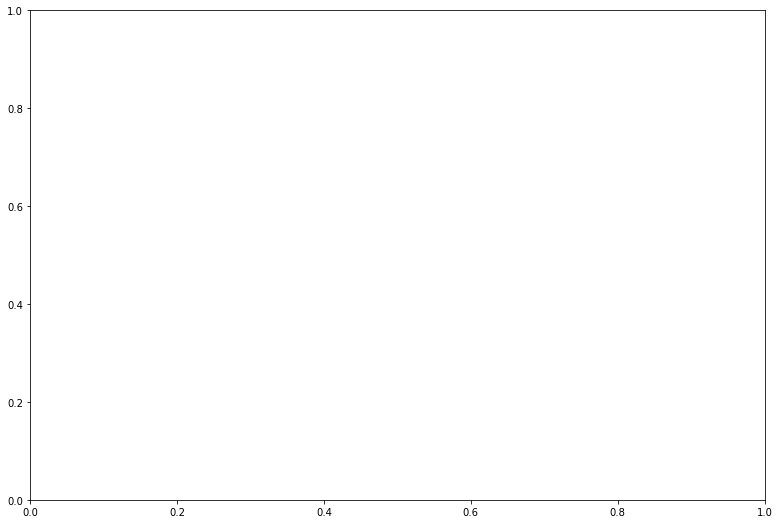

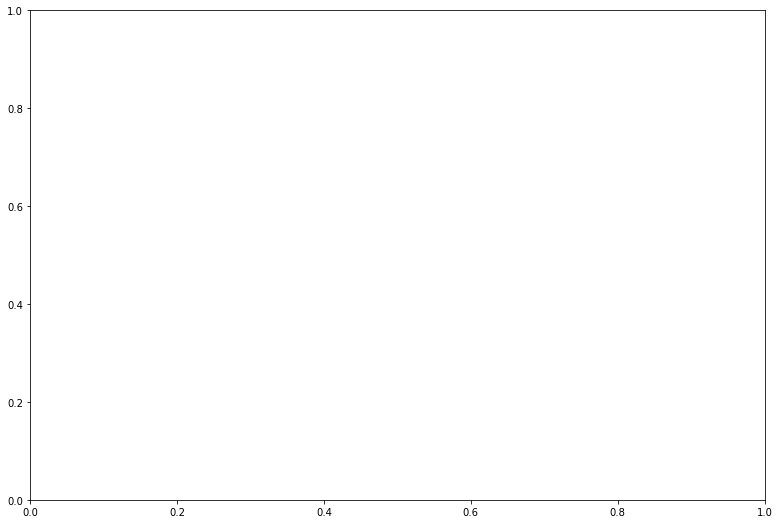

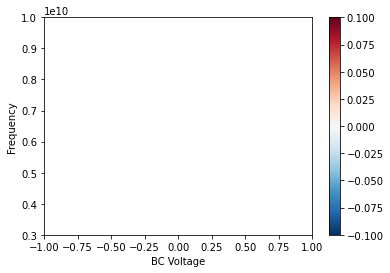

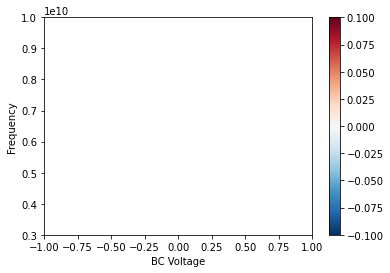

First sweep...Voltage set -1e+00 V
[-0.23124278+0.4201923j   0.34220597-0.1774846j  -0.21089898-0.01343032j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


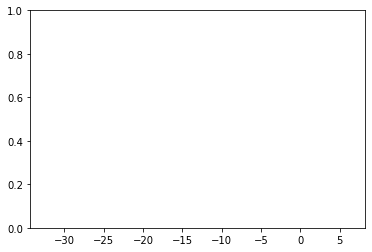

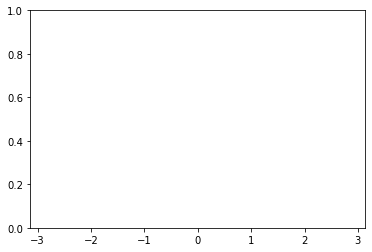

Time left: 0 h 0 m 4.9 s,	parameter values: BC Voltage:     -1,	average cycle time: 0.49s	Voltage set -8e-01 V
[-0.23125289+0.42018601j  0.34219861-0.1774947j  -0.21088368-0.0134306j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


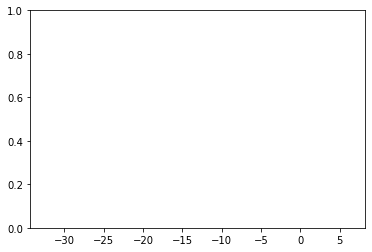

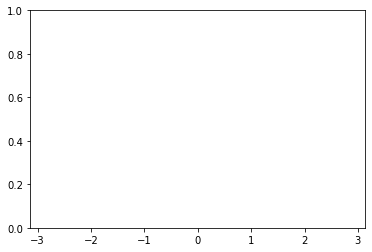

Time left: 0 h 0 m 4.56 s,	parameter values: BC Voltage:   -0.8,	average cycle time: 0.51s	Voltage set -6e-01 V
[-0.23125094+0.42018366j  0.34220344-0.1775191j  -0.21090269-0.0134089j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


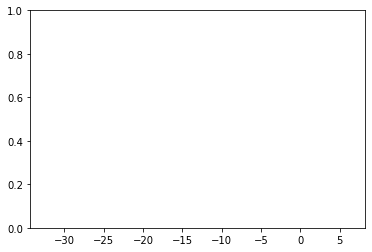

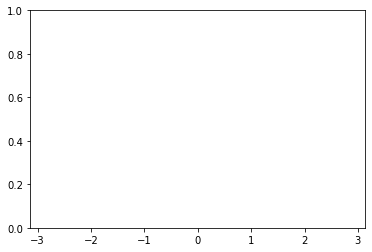

Time left: 0 h 0 m 4.13 s,	parameter values: BC Voltage:   -0.6,	average cycle time: 0.52s	Voltage set -4e-01 V
[-0.23125839+0.42019764j  0.34221584-0.17748849j -0.21088263-0.01343791j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


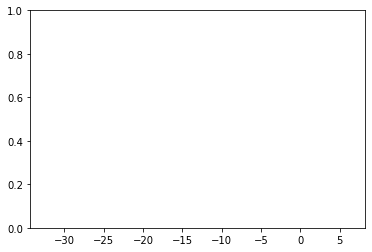

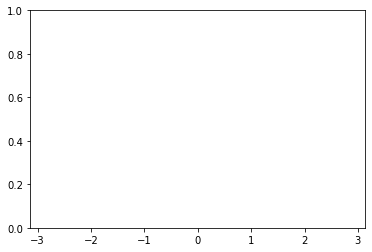

Time left: 0 h 0 m 3.62 s,	parameter values: BC Voltage:   -0.4,	average cycle time: 0.52s	Voltage set -2e-01 V
[-0.23128042+0.42018691j  0.34221601-0.17749113j -0.21086892-0.01344148j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


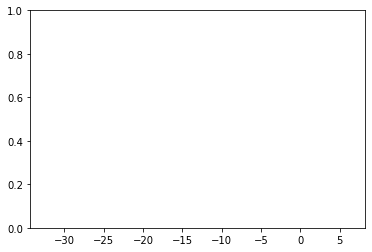

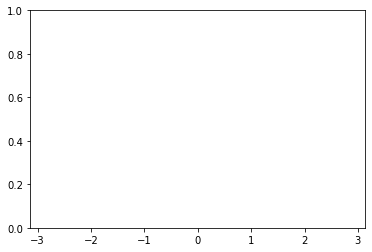

Time left: 0 h 0 m 3.24 s,	parameter values: BC Voltage:   -0.2,	average cycle time: 0.54s	Voltage set 0e+00 V
[-0.23125134+0.42021108j  0.34222007-0.17749298j -0.21093707-0.01341368j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


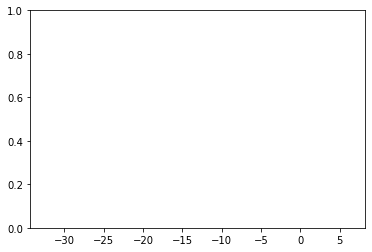

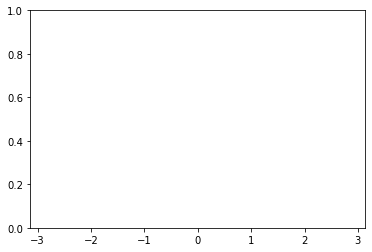

Time left: 0 h 0 m 2.69 s,	parameter values: BC Voltage:      0,	average cycle time: 0.54s	Voltage set 2e-01 V
[-0.23128429+0.42021188j  0.34223774-0.17748298j -0.21095207-0.0134211j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


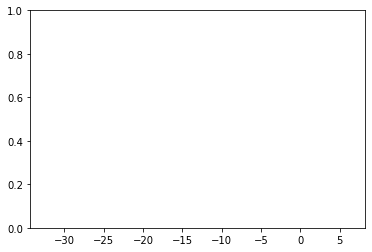

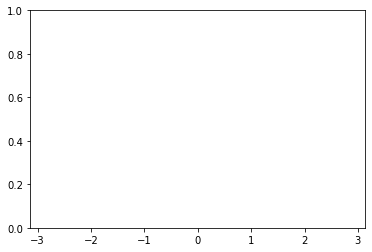

Time left: 0 h 0 m 2.17 s,	parameter values: BC Voltage:    0.2,	average cycle time: 0.54s	Voltage set 4e-01 V
[-0.23128609+0.42023113j  0.34227619-0.17749779j -0.21098651-0.01341923j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


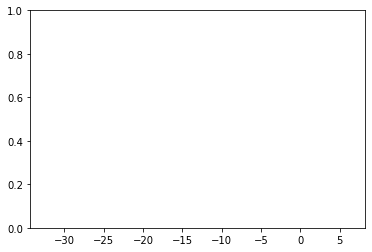

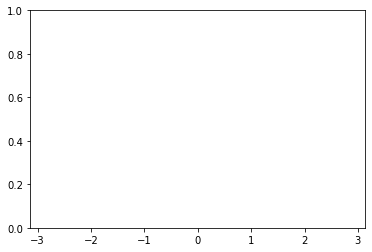

Time left: 0 h 0 m 1.63 s,	parameter values: BC Voltage:    0.4,	average cycle time: 0.54s	Voltage set 6e-01 V
[-0.23128328+0.42026252j  0.34228051-0.17750998j -0.21100001-0.01341919j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


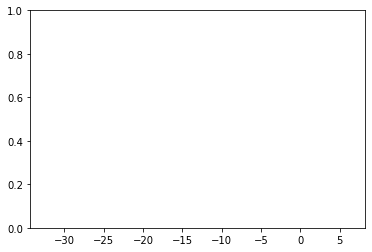

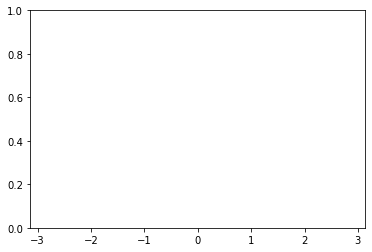

Time left: 0 h 0 m 1.08 s,	parameter values: BC Voltage:    0.6,	average cycle time: 0.54s	Voltage set 8e-01 V
[-0.2312692 +0.42021057j  0.34222257-0.17749727j -0.21096018-0.01339974j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


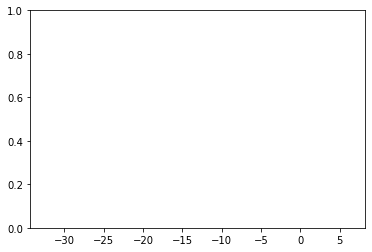

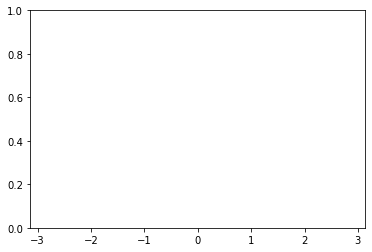

Time left: 0 h 0 m 0.54 s,	parameter values: BC Voltage:    0.8,	average cycle time: 0.54s	Voltage set 1e+00 V
[-0.23124163+0.42022842j  0.34222105-0.1774835j  -0.21095791-0.01339487j
 ...  0.21057467-0.08536146j -0.1763473 -0.16664259j
 -0.05243253+0.33267045j]


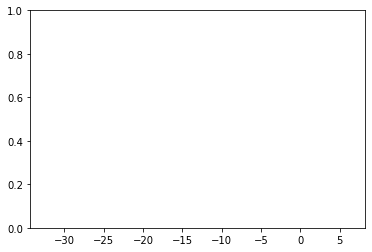

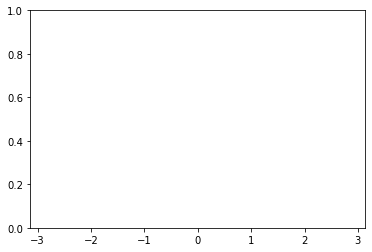

Time left: 0 h 0 m 0.0 s,	parameter values: BC Voltage:      1,	average cycle time: 0.54s	
Elapsed time: 0 h 0 m 6.0 s


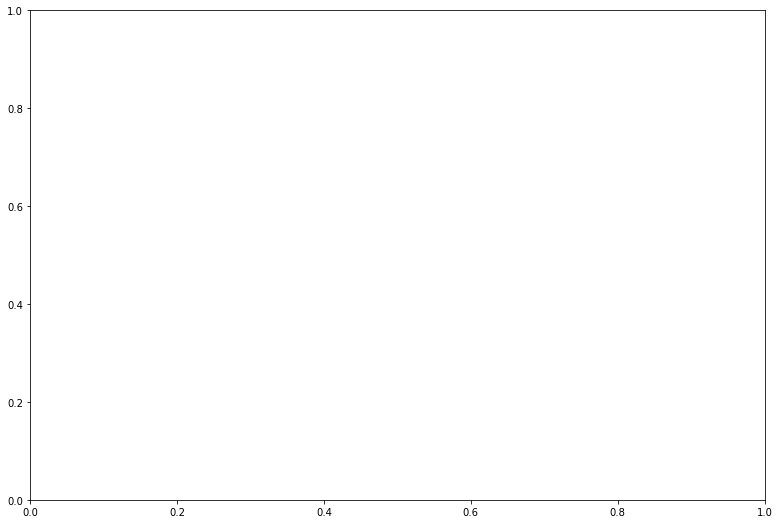

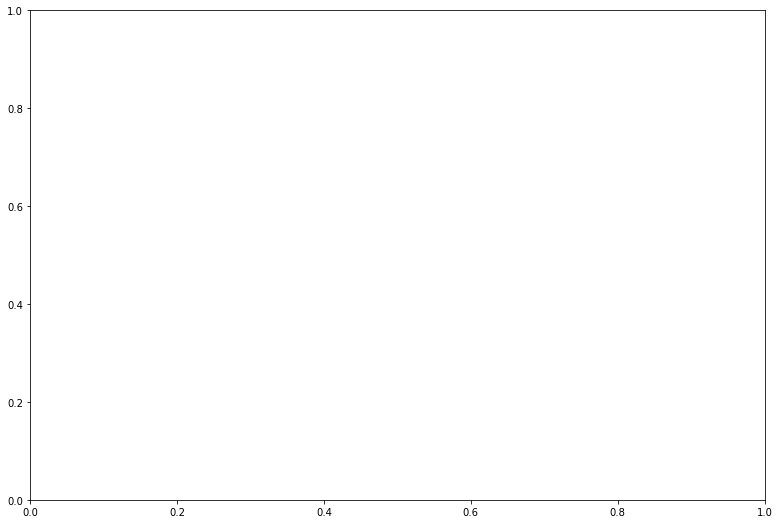

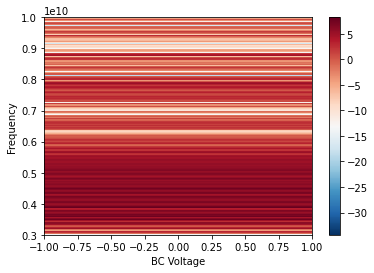

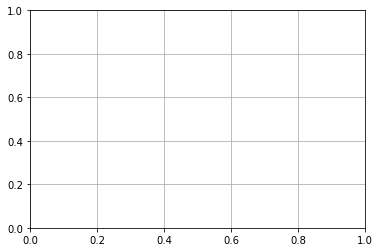

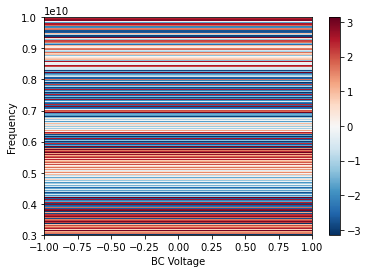

{'S-parameter': (('BC Voltage', 'Frequency'),
  (array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
   array([3.000e+09, 3.007e+09, 3.014e+09, ..., 9.986e+09, 9.993e+09,
          1.000e+10])),
  array([[-0.23124278+0.4201923j ,  0.34220597-0.1774846j ,
          -0.21089898-0.01343032j, ...,  0.21057467-0.08536146j,
          -0.1763473 -0.16664259j, -0.05243253+0.33267045j],
         [-0.23125289+0.42018601j,  0.34219861-0.1774947j ,
          -0.21088368-0.0134306j , ...,  0.21057467-0.08536146j,
          -0.1763473 -0.16664259j, -0.05243253+0.33267045j],
         [-0.23125094+0.42018366j,  0.34220344-0.1775191j ,
          -0.21090269-0.0134089j , ...,  0.21057467-0.08536146j,
          -0.1763473 -0.16664259j, -0.05243253+0.33267045j],
         ...,
         [-0.23128328+0.42026252j,  0.34228051-0.17750998j,
          -0.21100001-0.01341919j, ...,  0.21057467-0.08536146j,
          -0.1763473 -0.16664259j, -0.05243253+0.33267045j],
         [-0.2312692 +0.

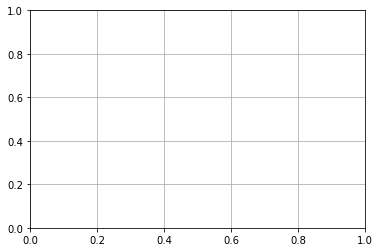

In [9]:
sweep.sweep(vna, (voltages, current_src_5.set_voltage, 'BC Voltage'), filename='Test sweep')

# SRS_SG386 Microwave signal generator Initialization

In [7]:
lo2 = SRS_SG380('SRS_SG386', address='Lo_27')  

modulation function: sine
modulation type: sweep


In [8]:
lo2.get_status()

0

In [9]:
lo2.set_frequency(5.998e9)

True

In [14]:
lo2.set_status(1)

True

In [20]:
lo2.set_modulation_function(1)

True

In [19]:
lo2.get_modulation_function()

modulation function: triangle


2

In [21]:
lo2.set_modulation_type(0)

True

In [22]:
lo2.get_modulation_type()

modulation type: AM


0

In [7]:
import pyvisa

In [8]:
rm = pyvisa.ResourceManager()

In [9]:
rm.list_resources()

('ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL4::INSTR',
 'GPIB0::5::INSTR',
 'GPIB0::27::INSTR',
 'GPIB1::5::INSTR',
 'GPIB0::10::INSTR',
 'GPIB0::16::INSTR',
 'GPIB0::17::INSTR',
 'GPIB0::1::INSTR',
 'GPIB0::22::INSTR',
 'GPIB0::26::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::4::INSTR',
 'GPIB0::6::INSTR',
 'GPIB0::7::INSTR',
 'GPIB0::8::INSTR',
 'GPIB0::9::0::INSTR',
 'TCPIP0::169.254.166.83::inst0::INSTR',
 'USB0::0x05FF::0x1023::2807N59061::0::INSTR',
 'USB0::0x0699::0x035E::C011901::0::INSTR',
 'USB0::0x0957::0x1796::MY51290236::0::INSTR',
 'USB0::0x0B5B::0xFFF9::1405051_776_47::0::INSTR',
 'USB0::0x2A8D::0xB318::MY59290070::0::INSTR')

In [10]:
my_instrument = rm.open_resource('GPIB0::27::INSTR', read_termination='\r\n')

In [12]:
responce = my_instrument.query("MFNC?")

In [15]:
responce

'0'

In [14]:
my_instrument.write("MFNC 3")

8

In [19]:
identity = my_instrument.query('*IDN?')

In [20]:
identity[26:31]

'SG386'